In [8]:
%pip install alpha-vantage
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd 
import numpy as np
import math
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from keras.layers import Dropout
import xgboost
import pickle

# GET DATA FROM API

In [10]:
API_KEY = 'N5E4Q2IN4MMPFWGY'

In [11]:
from alpha_vantage.timeseries import TimeSeries
ts = TimeSeries(key=API_KEY, output_format='pandas')
data = ts.get_intraday(symbol='MSFT',interval='15min', outputsize='full')
data = data[0]
data.rename(lambda x: x[2:].strip(), axis='columns', inplace=True)
data

,open,high,low,close,volume
date,,,,,
2023-08-18 19:45:00,316.750,317.000,316.520,316.990,1408.0
2023-08-18 19:30:00,316.680,316.980,316.460,316.950,1128.0
2023-08-18 19:15:00,316.450,316.700,316.450,316.680,1752.0
2023-08-18 19:00:00,316.750,316.750,316.400,316.480,1048.0
2023-08-18 18:45:00,316.970,316.970,316.500,316.750,2299.0
...,...,...,...,...,...
2023-07-21 05:00:00,348.015,348.107,347.824,348.055,1041.0
2023-07-21 04:45:00,348.115,348.207,347.814,347.976,3269.0
2023-07-21 04:30:00,347.956,348.107,347.764,348.105,3399.0


## Technical indicator for analyze data

In [12]:

from alpha_vantage.techindicators import TechIndicators
ti = TechIndicators(key=API_KEY, output_format='pandas')

### Rate of Change (ROC)

In [13]:
indicator_roc = ti.get_roc(symbol='MSFT', interval='15min', time_period=20)
indicator_roc = indicator_roc[0]
indicator_roc

,ROC
date,
2023-07-21 09:00:00,0.2840
2023-07-21 09:15:00,0.1434
2023-07-21 09:30:00,0.1778
2023-07-21 09:45:00,-0.2997
2023-07-21 10:00:00,-0.3583
...,...
2023-08-18 18:45:00,0.1296
2023-08-18 19:00:00,0.0759
2023-08-18 19:15:00,0.2057


### Simple Moving Average (SMA)

In [14]:
indicator_sma = ti.get_sma(symbol='MSFT', interval='15min', time_period=20)
indicator_sma = indicator_sma[0]
indicator_sma

,SMA
date,
2023-07-21 08:45:00,348.1857
2023-07-21 09:00:00,348.2351
2023-07-21 09:15:00,348.2600
2023-07-21 09:30:00,348.2910
2023-07-21 09:45:00,348.2388
...,...
2023-08-18 18:45:00,316.5584
2023-08-18 19:00:00,316.5704
2023-08-18 19:15:00,316.6029


### Relative Strength Index (RSI)

In [15]:
indicator_rsi = ti.get_rsi(symbol='MSFT', interval='15min', time_period=20)
indicator_rsi = indicator_rsi[0]
indicator_rsi

,RSI
date,
2023-07-21 09:00:00,58.2969
2023-07-21 09:15:00,54.0982
2023-07-21 09:30:00,56.1359
2023-07-21 09:45:00,42.8152
2023-07-21 10:00:00,42.0815
...,...
2023-08-18 18:45:00,54.4237
2023-08-18 19:00:00,52.3990
2023-08-18 19:15:00,53.7409


### Bolling Bands (BBANDS)

In [16]:
def BollingerBand(data, n_loockback, n_std=2):
    hlc_avg = (data.high + data.low + data.close)/3
    data_std = hlc_avg.rolling(window=n_loockback).std()
    data_upper = data.SMA + n_std * data_std
    data_lower = data.SMA - n_std * data_std
    return data.SMA, data_lower, data_upper

#### Merge indicators to data

In [17]:
original_df = pd.merge(data, indicator_roc, on='date', how='inner')
original_df = pd.merge(original_df, indicator_sma, on='date', how='inner')
original_df = pd.merge(original_df, indicator_rsi, on='date', how='inner')
# original_df = pd.merge(original_df, indicator_bb, on='date', how='inner')
original_df["Real Middle Band"], original_df["Real Lower Band"], original_df["Real Upper Band"] = BollingerBand(original_df, 20, 2)
original_df = original_df.dropna()
original_df = original_df.iloc[::-1]
original_df.to_csv('./DATA/MSFT.csv')
original_df

,open,high,low,close,volume,ROC,SMA,RSI,Real Middle Band,Real Lower Band,Real Upper Band
date,,,,,,,,,,,
2023-07-21 09:00:00,348.474,349.125,348.372,348.894,36667.0,0.2840,348.2351,58.2969,348.2351,345.318238,351.151962
2023-07-21 09:15:00,348.884,355.357,347.559,348.455,85578.0,0.1434,348.2600,54.0982,348.2600,345.477560,351.042440
2023-07-21 09:30:00,348.415,348.975,346.147,348.724,3084021.0,0.1778,348.2910,56.1359,348.2910,346.249993,350.332007
2023-07-21 09:45:00,348.724,349.564,346.931,346.933,1315197.0,-0.2997,348.2388,42.8152,348.2388,346.290877,350.186723
2023-07-21 10:00:00,346.929,347.698,345.808,346.808,1187090.0,-0.3583,348.1765,42.0815,348.1765,346.333639,350.019361
...,...,...,...,...,...,...,...,...,...,...,...
2023-08-18 14:00:00,316.330,316.910,314.020,316.240,328438.0,0.8965,315.0629,55.4110,315.0629,310.939754,319.186046
2023-08-18 14:15:00,316.210,316.560,315.620,316.030,257911.0,0.4865,315.1394,54.0768,315.1394,311.029516,319.249284
2023-08-18 14:30:00,316.020,316.730,315.920,316.220,386415.0,0.6205,315.2369,55.1063,315.2369,311.130989,319.342811


# MODEL TRAINING

## 1. LSTM

### a. Prepare Input

In [18]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close']].values
dataset

array([[348.894],
       [348.455],
       [348.724],
       ...,
       [316.22 ],
       [316.02 ],
       [315.63 ]])

In [19]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.95417748],
       [0.94278672],
       [0.94976648],
       ...,
       [0.10638298],
       [0.10119357],
       [0.09107421]])

In [20]:
X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])
print(len(X))
print(len(y))

1245
1245


In [21]:
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (996, 60, 1)
Size validate:  (125, 60, 1)
Size test:  (124, 60, 1)


### b. Train Model

In [22]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM.h5")

Epoch 1/20
32/32 [==============================] - 11s 87ms/step - loss: 0.0214 - val_loss: 0.0017
Epoch 2/20
32/32 [==============================] - 2s 54ms/step - loss: 0.0020 - val_loss: 8.4731e-04
Epoch 3/20
32/32 [==============================] - 2s 51ms/step - loss: 0.0015 - val_loss: 6.4668e-04
Epoch 4/20
32/32 [==============================] - 2s 53ms/step - loss: 0.0015 - val_loss: 6.5489e-04
Epoch 5/20
32/32 [==============================] - 2s 50ms/step - loss: 0.0014 - val_loss: 7.1393e-04
Epoch 6/20
32/32 [==============================] - 2s 71ms/step - loss: 0.0013 - val_loss: 6.9113e-04
Epoch 7/20
32/32 [==============================] - 2s 57ms/step - loss: 0.0012 - val_loss: 6.6020e-04
Epoch 8/20
32/32 [==============================] - 2s 58ms/step - loss: 0.0012 - val_loss: 6.5903e-04
Epoch 9/20
32/32 [==============================] - 2s 53ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 10/20
32/32 [==============================] - 2s 74ms/step - loss: 0.0013

C:\Users\lonel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### c. Test Model

In [23]:
model_lstm = load_model('./MODEL/LSTM.h5')

In [24]:
predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(predictions)

4/4 [==============================] - 1s 19ms/step


In [25]:
prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

C:\Users\lonel\AppData\Local\Temp\ipykernel_6528\2018918845.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


,date,open,high,low,close,volume,ROC,SMA,RSI,Real Middle Band,Real Lower Band,Real Upper Band,predictions
1181,2023-08-16 16:15:00,320.15,320.400,319.520,319.56,17773.0,-1.2057,321.5728,39.3984,321.5728,320.540449,322.605151,321.394745
1182,2023-08-16 16:30:00,319.57,320.400,319.550,319.95,51374.0,-0.9719,321.4158,41.7585,321.4158,320.374104,322.457496,321.079071
1183,2023-08-16 16:45:00,319.81,320.400,319.720,319.85,6604.0,-0.7478,321.2953,41.3242,321.2953,320.246201,322.344399,320.806122
1184,2023-08-16 17:00:00,319.85,320.400,319.750,319.95,1049919.0,-0.4914,321.2163,41.9597,321.2163,320.162124,322.270476,320.576050
1185,2023-08-16 17:15:00,319.95,335.997,306.526,320.00,4468.0,-0.5254,321.1318,42.2887,321.1318,320.072223,322.191377,320.405121
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1300,2023-08-18 14:00:00,316.33,316.910,314.020,316.24,328438.0,0.8965,315.0629,55.4110,315.0629,310.939754,319.186046,316.556061
1301,2023-08-18 14:15:00,316.21,316.560,315.620,316.03,257911.0,0.4865,315.1394,54.0768,315.1394,311.029516,319.249284,316.619141
1302,2023-08-18 14:30:00,316.02,316.730,315.920,316.22,386415.0,0.6205,315.2369,55.1063,315.2369,311.130989,319.342811,316.645264
1303,2023-08-18 14:45:00,316.17,316.610,315.930,316.02,313136.0,0.8650,315.3724,53.7707,315.3724,311.265616,319.479184,316.662079


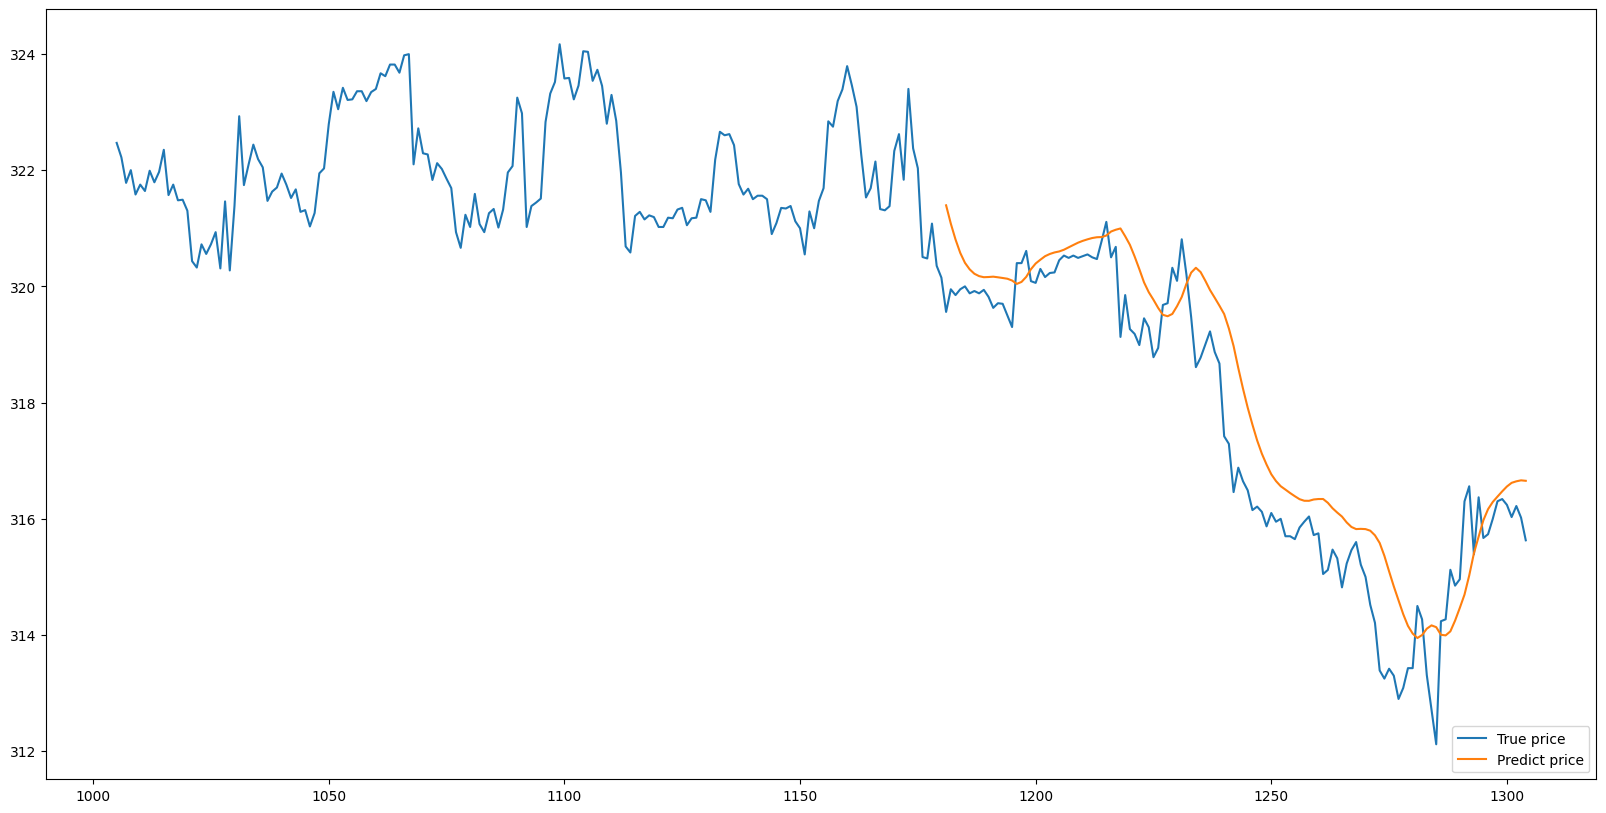

In [26]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### d. Combine Indicators

#### + ROC

In [27]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC']].values
dataset    

array([[3.48894e+02, 2.84000e-01],
       [3.48455e+02, 1.43400e-01],
       [3.48724e+02, 1.77800e-01],
       ...,
       [3.16220e+02, 6.20500e-01],
       [3.16020e+02, 8.65000e-01],
       [3.15630e+02, 9.33800e-01]])

In [28]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.95417748, 0.75679733],
       [0.94278672, 0.73308258],
       [0.94976648, 0.73888477],
       ...,
       [0.10638298, 0.81355418],
       [0.10119357, 0.85479355],
       [0.09107421, 0.86639792]])

In [29]:
X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])
print(len(X))
print(len(y))

1245
1245


In [30]:
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (996, 60, 2)
Size validate:  (125, 60, 2)
Size test:  (124, 60, 2)


In [31]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 2)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_ROC.h5")

Epoch 1/20
32/32 [==============================] - 8s 98ms/step - loss: 0.0165 - val_loss: 0.0012
Epoch 2/20
32/32 [==============================] - 2s 59ms/step - loss: 0.0022 - val_loss: 5.8065e-04
Epoch 3/20
32/32 [==============================] - 2s 64ms/step - loss: 0.0015 - val_loss: 5.6899e-04
Epoch 4/20
32/32 [==============================] - 2s 61ms/step - loss: 0.0013 - val_loss: 5.7525e-04
Epoch 5/20
32/32 [==============================] - 2s 67ms/step - loss: 0.0012 - val_loss: 6.5984e-04
Epoch 6/20
32/32 [==============================] - 2s 58ms/step - loss: 0.0012 - val_loss: 5.7062e-04
Epoch 7/20
32/32 [==============================] - 2s 62ms/step - loss: 0.0011 - val_loss: 6.1513e-04
Epoch 8/20
32/32 [==============================] - 2s 63ms/step - loss: 0.0010 - val_loss: 6.0042e-04
Epoch 9/20
32/32 [==============================] - 2s 62ms/step - loss: 9.7758e-04 - val_loss: 7.7995e-04
Epoch 10/20
32/32 [==============================] - 2s 58ms/step - loss:

C:\Users\lonel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [32]:
model_lstm = load_model('./MODEL/LSTM_ROC.h5')

In [33]:
predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]
predictions

4/4 [==============================] - 1s 21ms/step


array([320.84296, 320.53442, 320.36096, 320.30923, 320.3674 , 320.44232,
       320.45502, 320.49088, 320.50668, 320.50018, 320.39563, 320.22485,
       320.11716, 319.94516, 319.82864, 319.74448, 319.92996, 320.18225,
       320.40408, 320.5496 , 320.63153, 320.72757, 320.74554, 320.73367,
       320.69418, 320.6696 , 320.67172, 320.675  , 320.68762, 320.6935 ,
       320.7104 , 320.74643, 320.7715 , 320.78555, 320.8501 , 320.98434,
       320.96692, 320.93042, 320.66623, 320.489  , 320.2884 , 320.08163,
       319.88696, 319.78406, 319.7152 , 319.59058, 319.4808 , 319.4989 ,
       319.57462, 319.75684, 319.9299 , 320.1761 , 320.33826, 320.3418 ,
       320.1333 , 319.86392, 319.67636, 319.56326, 319.547  , 319.4799 ,
       319.25998, 318.97565, 318.58664, 318.21994, 317.8868 , 317.6199 ,
       317.3557 , 317.09027, 316.8541 , 316.60318, 316.43408, 316.2736 ,
       316.19354, 316.16626, 316.20663, 316.23914, 316.26352, 316.27304,
       316.3019 , 316.2984 , 316.34515, 316.30203, 

In [34]:
prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

C:\Users\lonel\AppData\Local\Temp\ipykernel_6528\2018918845.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


,date,open,high,low,close,volume,ROC,SMA,RSI,Real Middle Band,Real Lower Band,Real Upper Band,predictions
1181,2023-08-16 16:15:00,320.15,320.400,319.520,319.56,17773.0,-1.2057,321.5728,39.3984,321.5728,320.540449,322.605151,320.842957
1182,2023-08-16 16:30:00,319.57,320.400,319.550,319.95,51374.0,-0.9719,321.4158,41.7585,321.4158,320.374104,322.457496,320.534424
1183,2023-08-16 16:45:00,319.81,320.400,319.720,319.85,6604.0,-0.7478,321.2953,41.3242,321.2953,320.246201,322.344399,320.360962
1184,2023-08-16 17:00:00,319.85,320.400,319.750,319.95,1049919.0,-0.4914,321.2163,41.9597,321.2163,320.162124,322.270476,320.309235
1185,2023-08-16 17:15:00,319.95,335.997,306.526,320.00,4468.0,-0.5254,321.1318,42.2887,321.1318,320.072223,322.191377,320.367401
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1300,2023-08-18 14:00:00,316.33,316.910,314.020,316.24,328438.0,0.8965,315.0629,55.4110,315.0629,310.939754,319.186046,316.670105
1301,2023-08-18 14:15:00,316.21,316.560,315.620,316.03,257911.0,0.4865,315.1394,54.0768,315.1394,311.029516,319.249284,316.683655
1302,2023-08-18 14:30:00,316.02,316.730,315.920,316.22,386415.0,0.6205,315.2369,55.1063,315.2369,311.130989,319.342811,316.596191
1303,2023-08-18 14:45:00,316.17,316.610,315.930,316.02,313136.0,0.8650,315.3724,53.7707,315.3724,311.265616,319.479184,316.531250


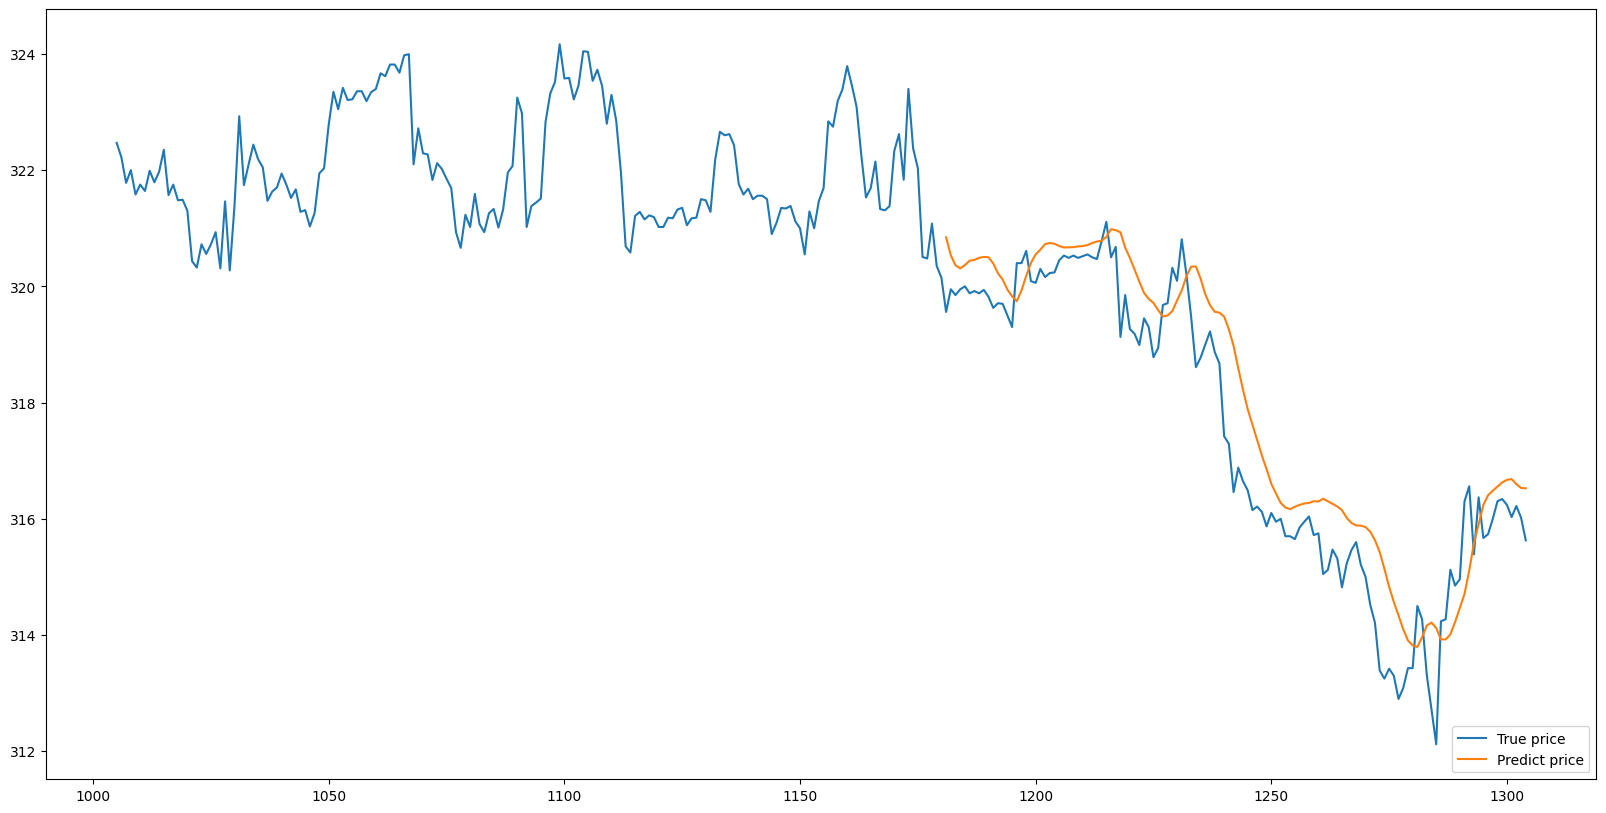

In [35]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + SMA

In [36]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 2)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_SMA.h5")


Epoch 1/20
32/32 [==============================] - 7s 91ms/step - loss: 0.0389 - val_loss: 0.0076
Epoch 2/20
32/32 [==============================] - 2s 48ms/step - loss: 0.0034 - val_loss: 0.0010
Epoch 3/20
32/32 [==============================] - 2s 55ms/step - loss: 0.0024 - val_loss: 7.9630e-04
Epoch 4/20
32/32 [==============================] - 2s 49ms/step - loss: 0.0020 - val_loss: 8.3626e-04
Epoch 5/20
32/32 [==============================] - 2s 50ms/step - loss: 0.0018 - val_loss: 8.2078e-04
Epoch 6/20
32/32 [==============================] - 2s 55ms/step - loss: 0.0017 - val_loss: 7.3883e-04
Epoch 7/20
32/32 [==============================] - 2s 69ms/step - loss: 0.0015 - val_loss: 6.9674e-04
Epoch 8/20
32/32 [==============================] - 3s 101ms/step - loss: 0.0014 - val_loss: 7.1448e-04
Epoch 9/20
32/32 [==============================] - 2s 75ms/step - loss: 0.0014 - val_loss: 6.5235e-04
Epoch 10/20
32/32 [==============================] - 2s 73ms/step - loss: 0.0012

C:\Users\lonel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [37]:
model_lstm = load_model('./MODEL/LSTM_SMA.h5')


4/4 [==============================] - 2s 20ms/step


C:\Users\lonel\AppData\Local\Temp\ipykernel_6528\3901828709.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


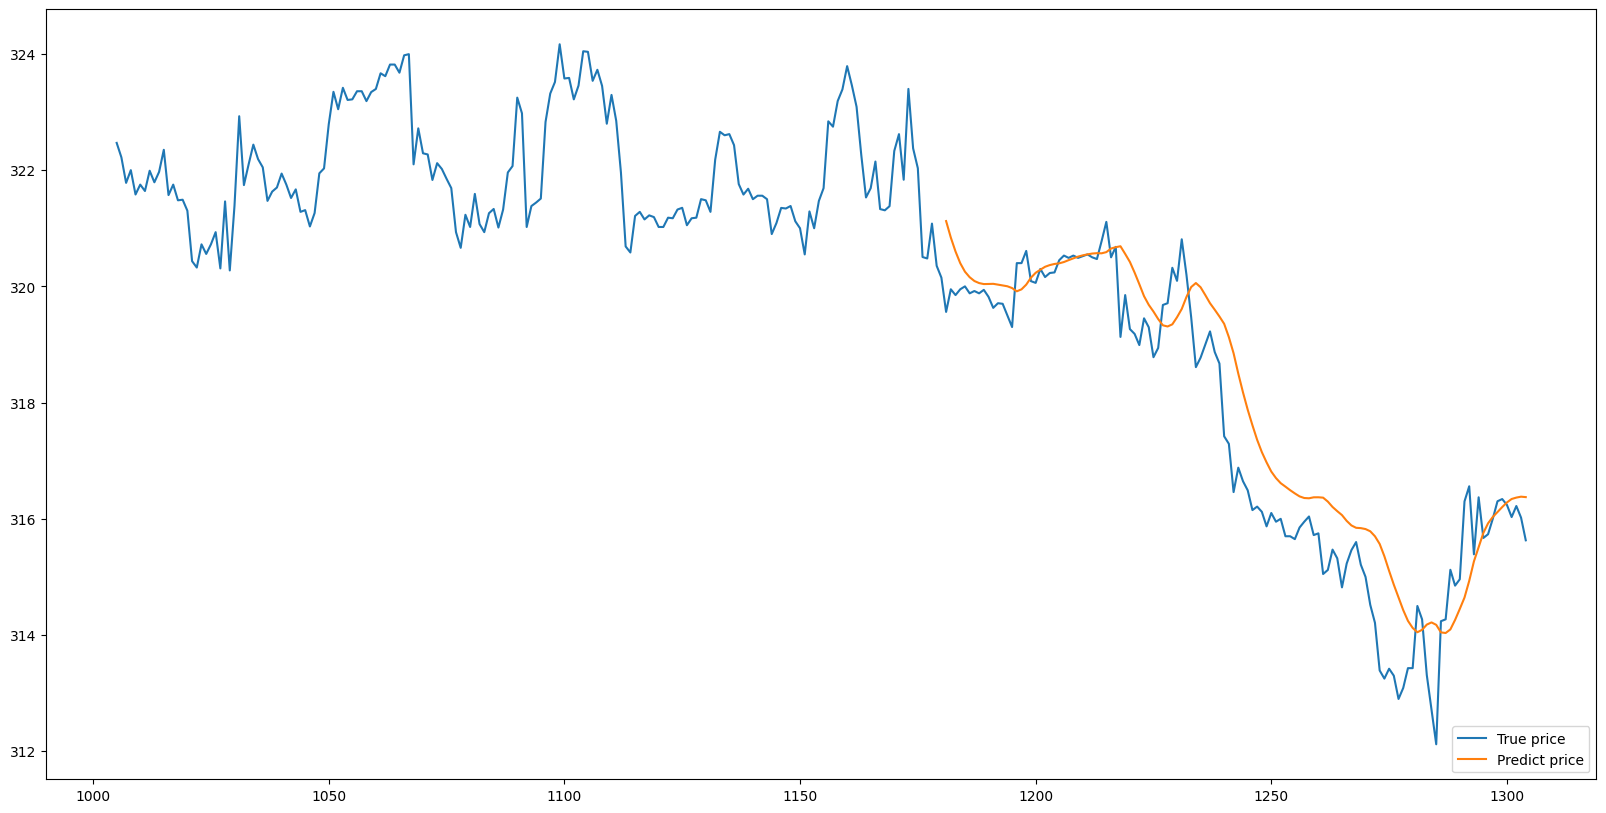

In [38]:
predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI

In [39]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 2)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_RSI.h5")

Epoch 1/20
32/32 [==============================] - 10s 92ms/step - loss: 0.0196 - val_loss: 7.8905e-04
Epoch 2/20
32/32 [==============================] - 2s 54ms/step - loss: 0.0018 - val_loss: 5.1592e-04
Epoch 3/20
32/32 [==============================] - 2s 58ms/step - loss: 0.0011 - val_loss: 6.3557e-04
Epoch 4/20
32/32 [==============================] - 2s 63ms/step - loss: 0.0010 - val_loss: 5.2919e-04
Epoch 5/20
32/32 [==============================] - 2s 47ms/step - loss: 9.4171e-04 - val_loss: 5.3187e-04
Epoch 6/20
32/32 [==============================] - 2s 47ms/step - loss: 9.6556e-04 - val_loss: 7.6052e-04
Epoch 7/20
32/32 [==============================] - 2s 47ms/step - loss: 9.7734e-04 - val_loss: 4.5283e-04
Epoch 8/20
32/32 [==============================] - 1s 47ms/step - loss: 8.5694e-04 - val_loss: 4.3146e-04
Epoch 9/20
32/32 [==============================] - 1s 46ms/step - loss: 8.8004e-04 - val_loss: 4.5254e-04
Epoch 10/20
32/32 [==============================] -

C:\Users\lonel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [40]:
model_lstm = load_model('./MODEL/LSTM_RSI.h5')


4/4 [==============================] - 1s 19ms/step


C:\Users\lonel\AppData\Local\Temp\ipykernel_6528\3901828709.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


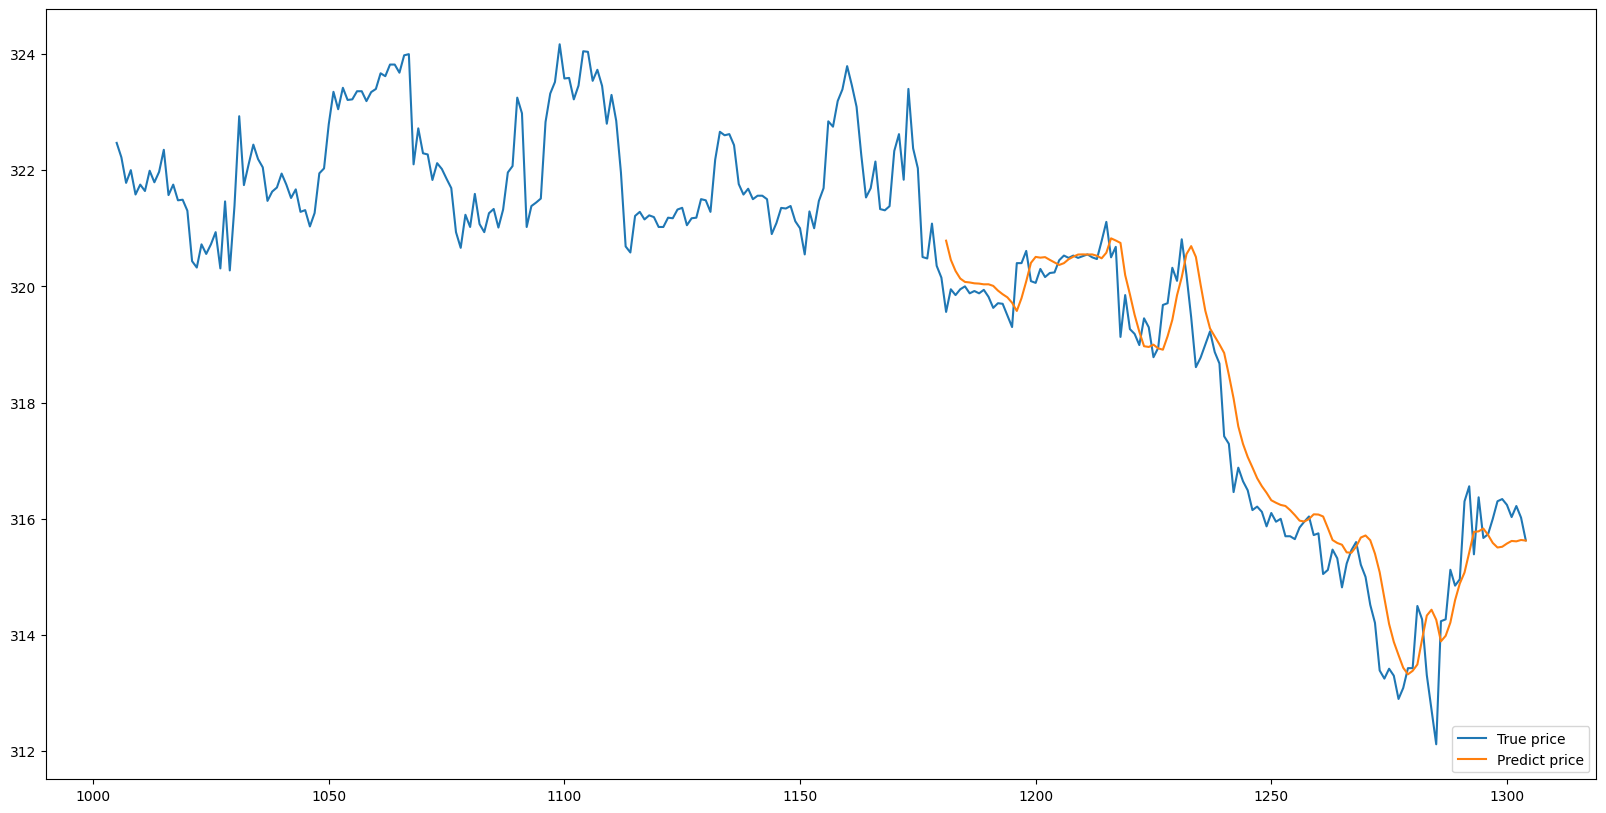

In [41]:
predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS

In [42]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS.h5")

Epoch 1/20
32/32 [==============================] - 8s 84ms/step - loss: 0.0308 - val_loss: 0.0039
Epoch 2/20
32/32 [==============================] - 2s 49ms/step - loss: 0.0043 - val_loss: 0.0013
Epoch 3/20
32/32 [==============================] - 2s 53ms/step - loss: 0.0029 - val_loss: 9.2926e-04
Epoch 4/20
32/32 [==============================] - 2s 53ms/step - loss: 0.0025 - val_loss: 9.2019e-04
Epoch 5/20
32/32 [==============================] - 2s 49ms/step - loss: 0.0023 - val_loss: 8.5375e-04
Epoch 6/20
32/32 [==============================] - 2s 50ms/step - loss: 0.0020 - val_loss: 7.9404e-04
Epoch 7/20
32/32 [==============================] - 2s 57ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 8/20
32/32 [==============================] - 2s 48ms/step - loss: 0.0016 - val_loss: 7.7778e-04
Epoch 9/20
32/32 [==============================] - 1s 46ms/step - loss: 0.0016 - val_loss: 7.2304e-04
Epoch 10/20
32/32 [==============================] - 1s 45ms/step - loss: 0.0011 - va

C:\Users\lonel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [43]:
model_lstm = load_model('./MODEL/LSTM_BBANDS.h5')


4/4 [==============================] - 1s 17ms/step


C:\Users\lonel\AppData\Local\Temp\ipykernel_6528\3901828709.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


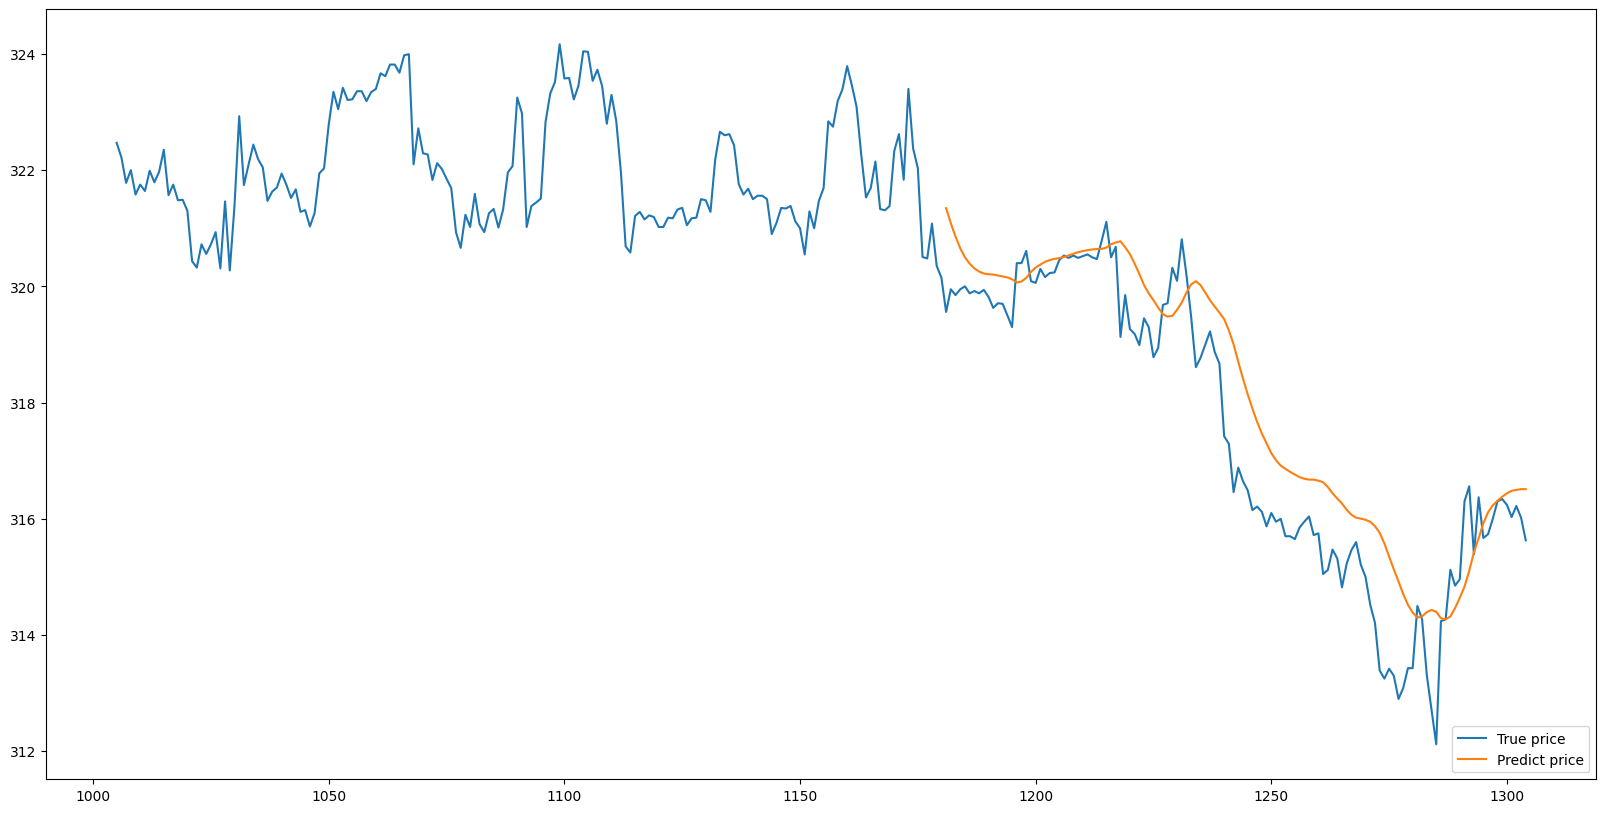

In [44]:
predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC

In [45]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_ROC.h5")

Epoch 1/20
32/32 [==============================] - 9s 97ms/step - loss: 0.0359 - val_loss: 0.0015
Epoch 2/20
32/32 [==============================] - 2s 62ms/step - loss: 0.0033 - val_loss: 9.9218e-04
Epoch 3/20
32/32 [==============================] - 4s 116ms/step - loss: 0.0024 - val_loss: 7.9476e-04
Epoch 4/20
32/32 [==============================] - 4s 123ms/step - loss: 0.0019 - val_loss: 8.6097e-04
Epoch 5/20
32/32 [==============================] - 3s 83ms/step - loss: 0.0014 - val_loss: 7.6673e-04
Epoch 6/20
32/32 [==============================] - 3s 92ms/step - loss: 0.0013 - val_loss: 7.1714e-04
Epoch 7/20
32/32 [==============================] - 3s 105ms/step - loss: 0.0013 - val_loss: 6.8619e-04
Epoch 8/20
32/32 [==============================] - 3s 89ms/step - loss: 0.0012 - val_loss: 6.5618e-04
Epoch 9/20
32/32 [==============================] - 3s 84ms/step - loss: 0.0012 - val_loss: 7.9747e-04
Epoch 10/20
32/32 [==============================] - 2s 74ms/step - loss: 

C:\Users\lonel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [46]:
model_lstm = load_model('./MODEL/LSTM_BBANDS_ROC.h5')

4/4 [==============================] - 1s 23ms/step


C:\Users\lonel\AppData\Local\Temp\ipykernel_6528\3901828709.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


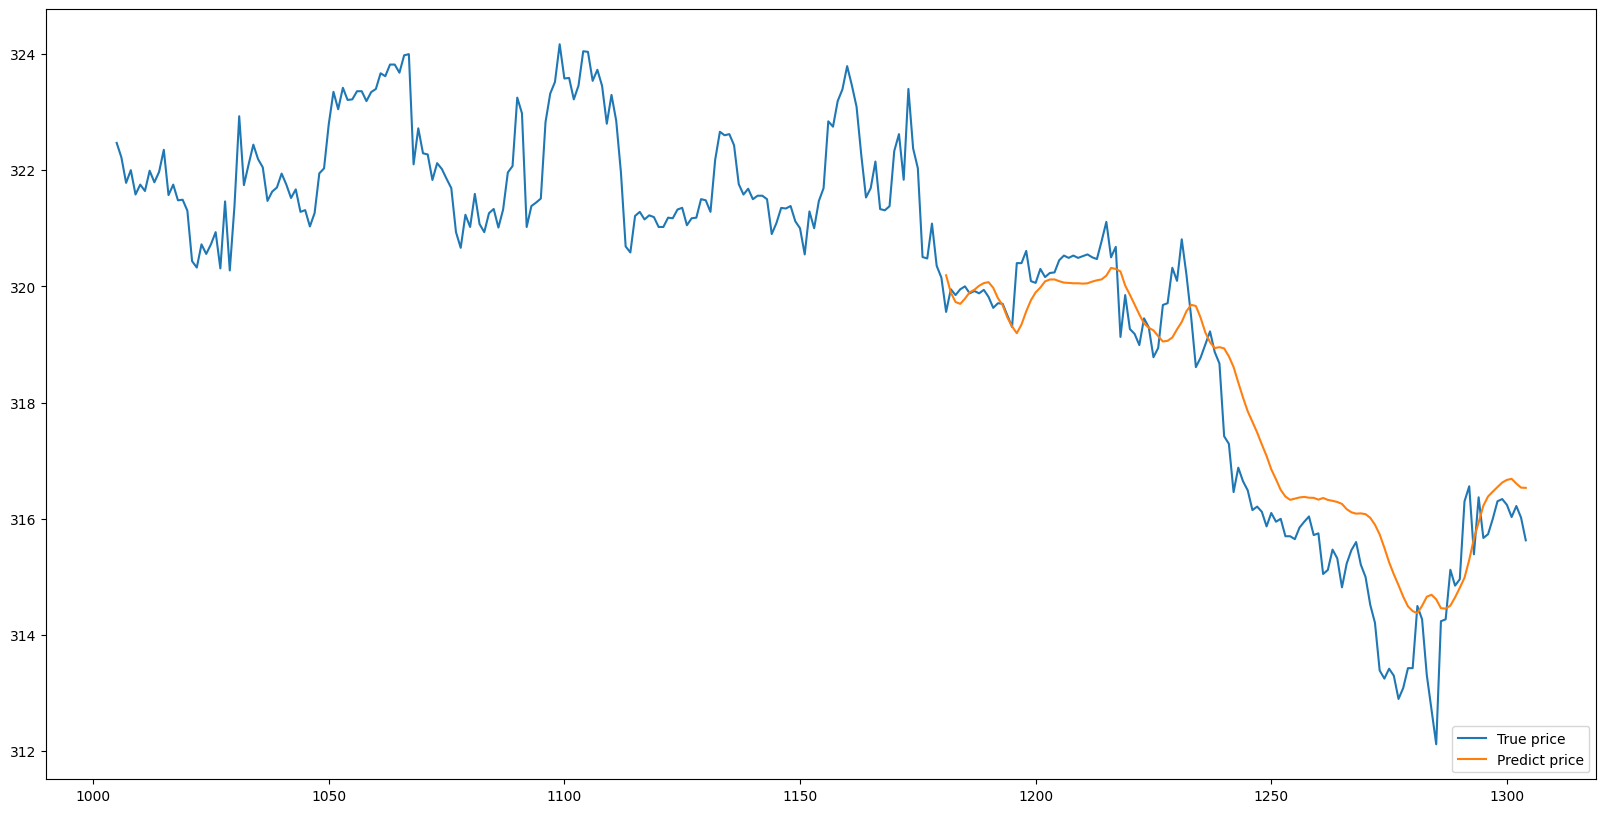

In [47]:
predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI

Epoch 1/20
32/32 [==============================] - 10s 96ms/step - loss: 0.0274 - val_loss: 0.0014
Epoch 2/20
32/32 [==============================] - 2s 57ms/step - loss: 0.0023 - val_loss: 9.4380e-04
Epoch 3/20
32/32 [==============================] - 2s 62ms/step - loss: 0.0014 - val_loss: 6.8662e-04
Epoch 4/20
32/32 [==============================] - 2s 71ms/step - loss: 0.0011 - val_loss: 5.4099e-04
Epoch 5/20
32/32 [==============================] - 3s 81ms/step - loss: 9.9442e-04 - val_loss: 5.4746e-04
Epoch 6/20
32/32 [==============================] - 2s 66ms/step - loss: 8.8454e-04 - val_loss: 5.4278e-04
Epoch 7/20
32/32 [==============================] - 2s 55ms/step - loss: 8.3301e-04 - val_loss: 5.4446e-04
Epoch 8/20
32/32 [==============================] - 2s 60ms/step - loss: 8.3260e-04 - val_loss: 4.3228e-04
Epoch 9/20
32/32 [==============================] - 2s 65ms/step - loss: 7.7170e-04 - val_loss: 4.3120e-04
Epoch 10/20
32/32 [==============================] - 2s 

C:\Users\lonel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 1s 21ms/step


C:\Users\lonel\AppData\Local\Temp\ipykernel_6528\3535381047.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


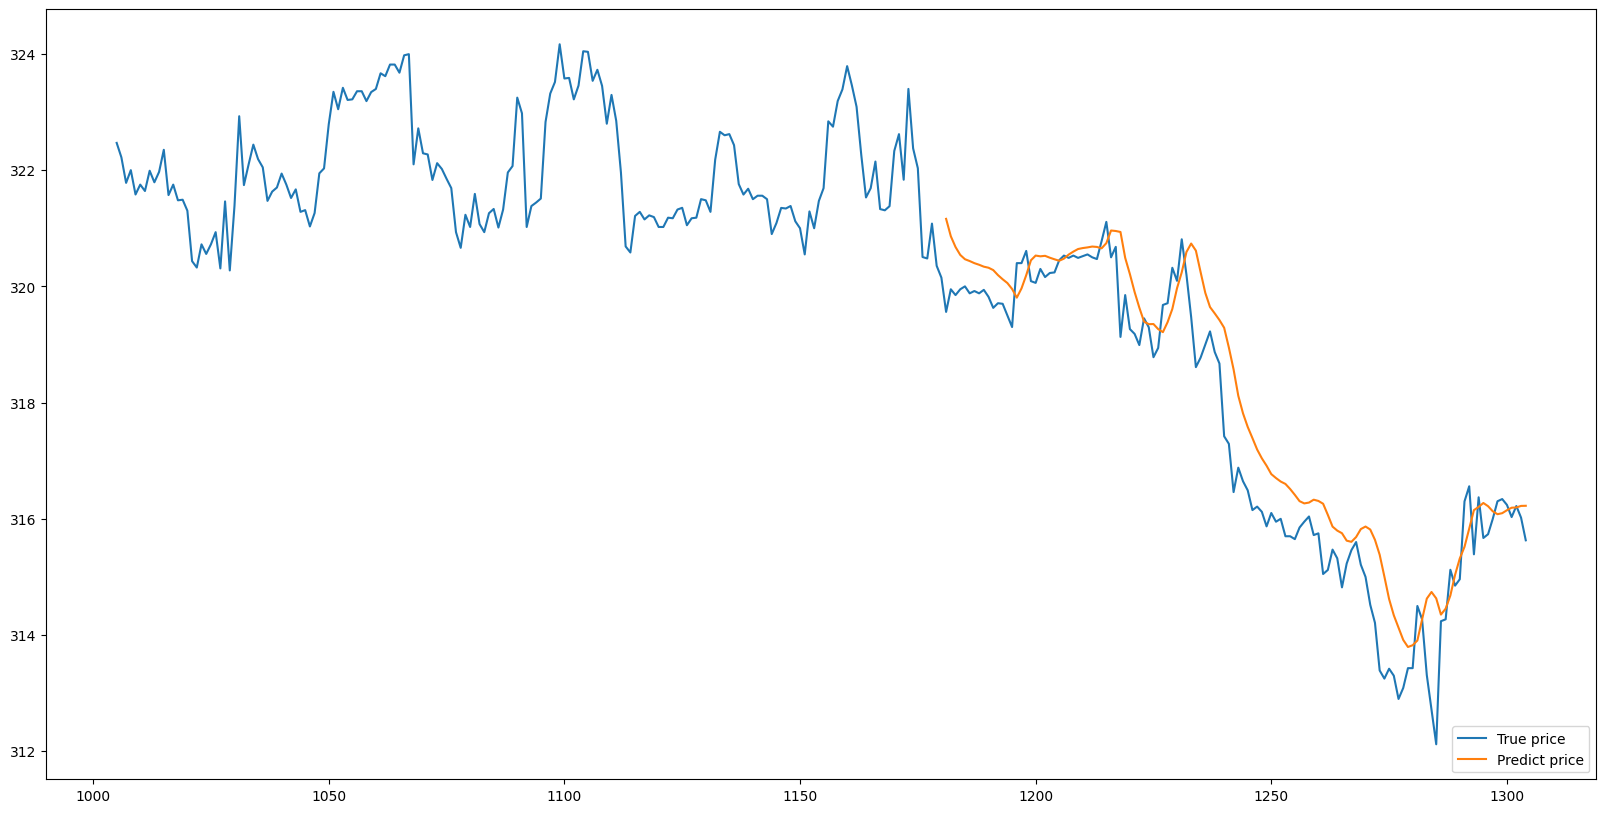

In [48]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_RSI.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_RSI.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + SMA

Epoch 1/20
32/32 [==============================] - 8s 88ms/step - loss: 0.0099 - val_loss: 0.0015
Epoch 2/20
32/32 [==============================] - 2s 51ms/step - loss: 0.0028 - val_loss: 9.1327e-04
Epoch 3/20
32/32 [==============================] - 2s 53ms/step - loss: 0.0021 - val_loss: 8.5611e-04
Epoch 4/20
32/32 [==============================] - 2s 55ms/step - loss: 0.0014 - val_loss: 8.0438e-04
Epoch 5/20
32/32 [==============================] - 2s 54ms/step - loss: 0.0012 - val_loss: 6.3139e-04
Epoch 6/20
32/32 [==============================] - 2s 53ms/step - loss: 0.0011 - val_loss: 6.3156e-04
Epoch 7/20
32/32 [==============================] - 3s 82ms/step - loss: 0.0012 - val_loss: 5.4077e-04
Epoch 8/20
32/32 [==============================] - 2s 54ms/step - loss: 0.0010 - val_loss: 5.2833e-04
Epoch 9/20
32/32 [==============================] - 2s 68ms/step - loss: 8.6517e-04 - val_loss: 5.3248e-04
Epoch 10/20
32/32 [==============================] - 2s 66ms/step - loss:

C:\Users\lonel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 2s 27ms/step


C:\Users\lonel\AppData\Local\Temp\ipykernel_6528\673527183.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


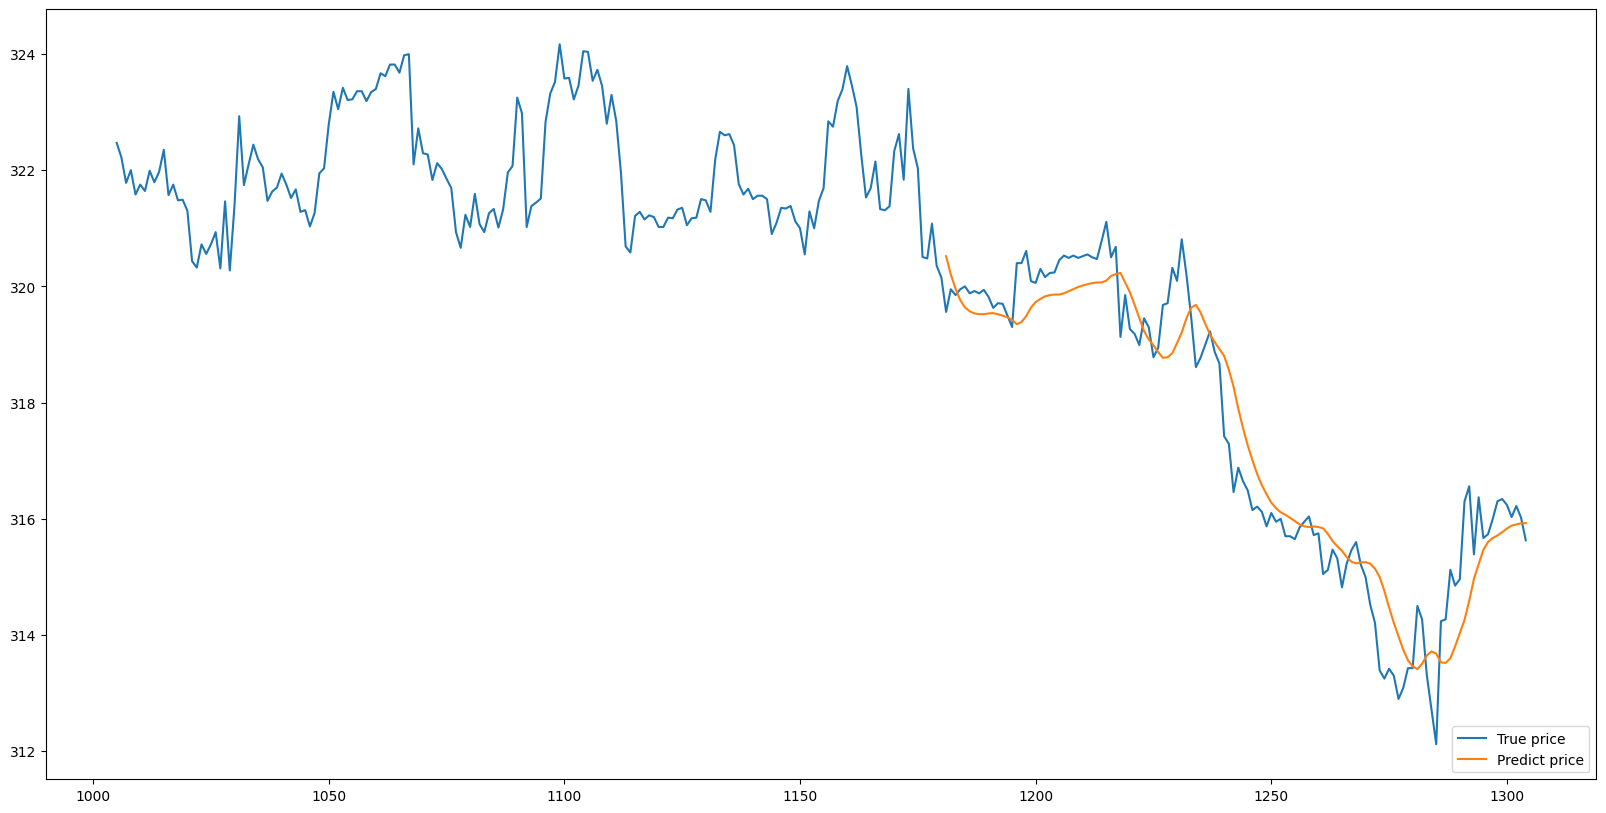

In [49]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI

Epoch 1/20
32/32 [==============================] - 8s 92ms/step - loss: 0.0302 - val_loss: 8.1294e-04
Epoch 2/20
32/32 [==============================] - 2s 57ms/step - loss: 0.0023 - val_loss: 6.7853e-04
Epoch 3/20
32/32 [==============================] - 2s 51ms/step - loss: 0.0013 - val_loss: 6.7528e-04
Epoch 4/20
32/32 [==============================] - 2s 55ms/step - loss: 0.0011 - val_loss: 6.3091e-04
Epoch 5/20
32/32 [==============================] - 2s 54ms/step - loss: 0.0010 - val_loss: 6.0598e-04
Epoch 6/20
32/32 [==============================] - 2s 56ms/step - loss: 9.6823e-04 - val_loss: 5.2028e-04
Epoch 7/20
32/32 [==============================] - 2s 55ms/step - loss: 9.4780e-04 - val_loss: 4.8766e-04
Epoch 8/20
32/32 [==============================] - 2s 56ms/step - loss: 8.8912e-04 - val_loss: 4.6815e-04
Epoch 9/20
32/32 [==============================] - 2s 57ms/step - loss: 8.5728e-04 - val_loss: 4.8727e-04
Epoch 10/20
32/32 [==============================] - 2s 5

C:\Users\lonel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 1s 17ms/step


C:\Users\lonel\AppData\Local\Temp\ipykernel_6528\2565469263.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


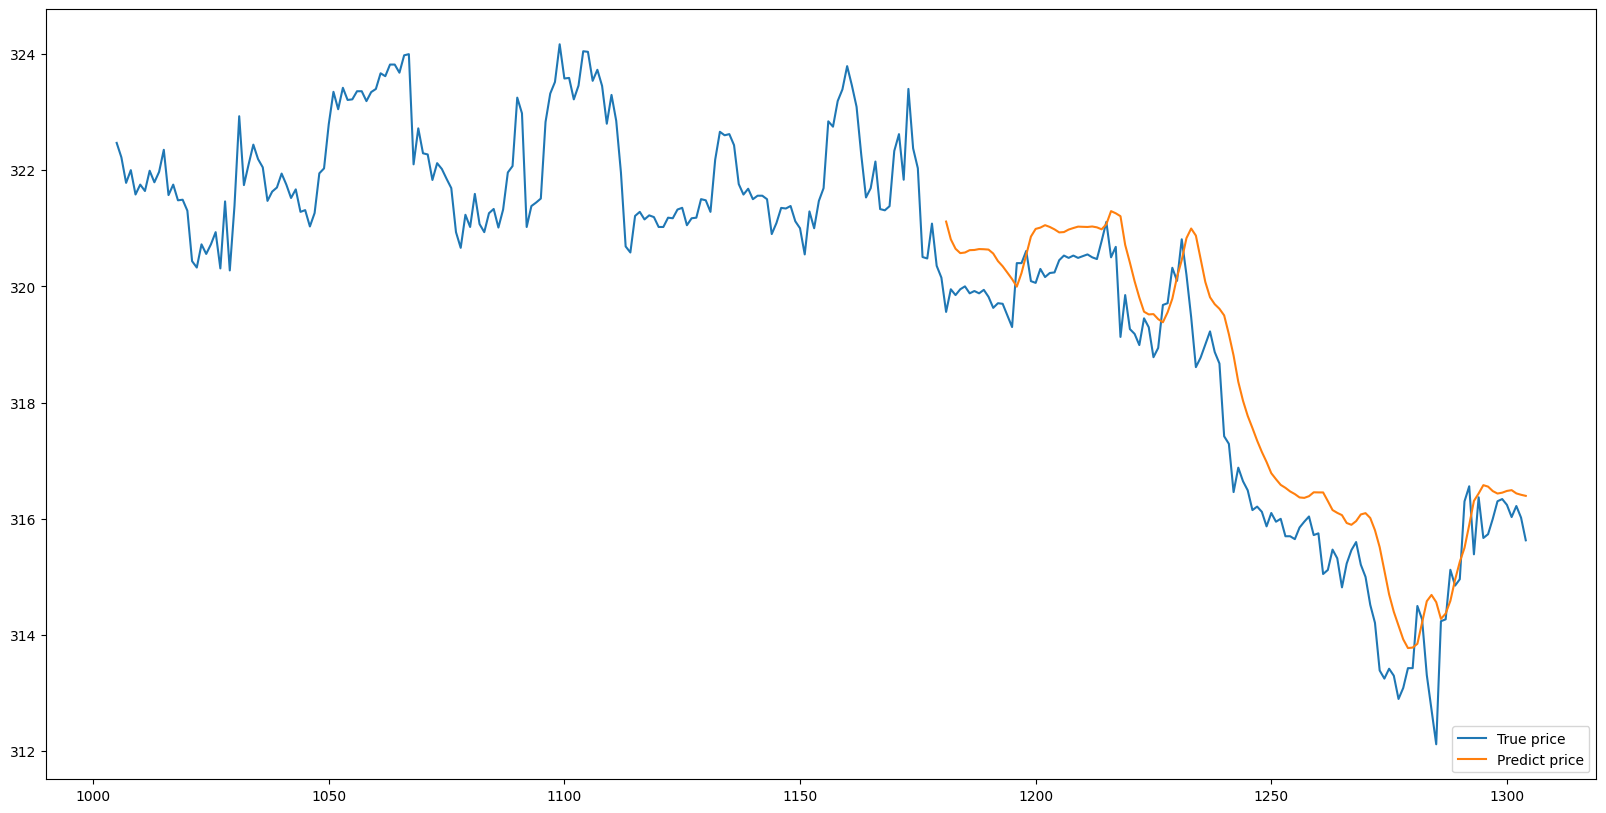

In [50]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_ROC_RSI.h5")

model_lstm = load_model('./MODEL/LSTM_ROC_RSI.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + SMA

Epoch 1/20
32/32 [==============================] - 8s 89ms/step - loss: 0.0324 - val_loss: 0.0022
Epoch 2/20
32/32 [==============================] - 2s 62ms/step - loss: 0.0034 - val_loss: 8.5783e-04
Epoch 3/20
32/32 [==============================] - 2s 52ms/step - loss: 0.0026 - val_loss: 7.8408e-04
Epoch 4/20
32/32 [==============================] - 2s 53ms/step - loss: 0.0021 - val_loss: 7.6342e-04
Epoch 5/20
32/32 [==============================] - 2s 64ms/step - loss: 0.0017 - val_loss: 7.0932e-04
Epoch 6/20
32/32 [==============================] - 2s 52ms/step - loss: 0.0015 - val_loss: 6.9823e-04
Epoch 7/20
32/32 [==============================] - 2s 54ms/step - loss: 0.0014 - val_loss: 6.7412e-04
Epoch 8/20
32/32 [==============================] - 2s 53ms/step - loss: 0.0014 - val_loss: 8.5155e-04
Epoch 9/20
32/32 [==============================] - 2s 53ms/step - loss: 0.0013 - val_loss: 6.3213e-04
Epoch 10/20
32/32 [==============================] - 2s 53ms/step - loss: 0.0

C:\Users\lonel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 1s 19ms/step


C:\Users\lonel\AppData\Local\Temp\ipykernel_6528\2020499875.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


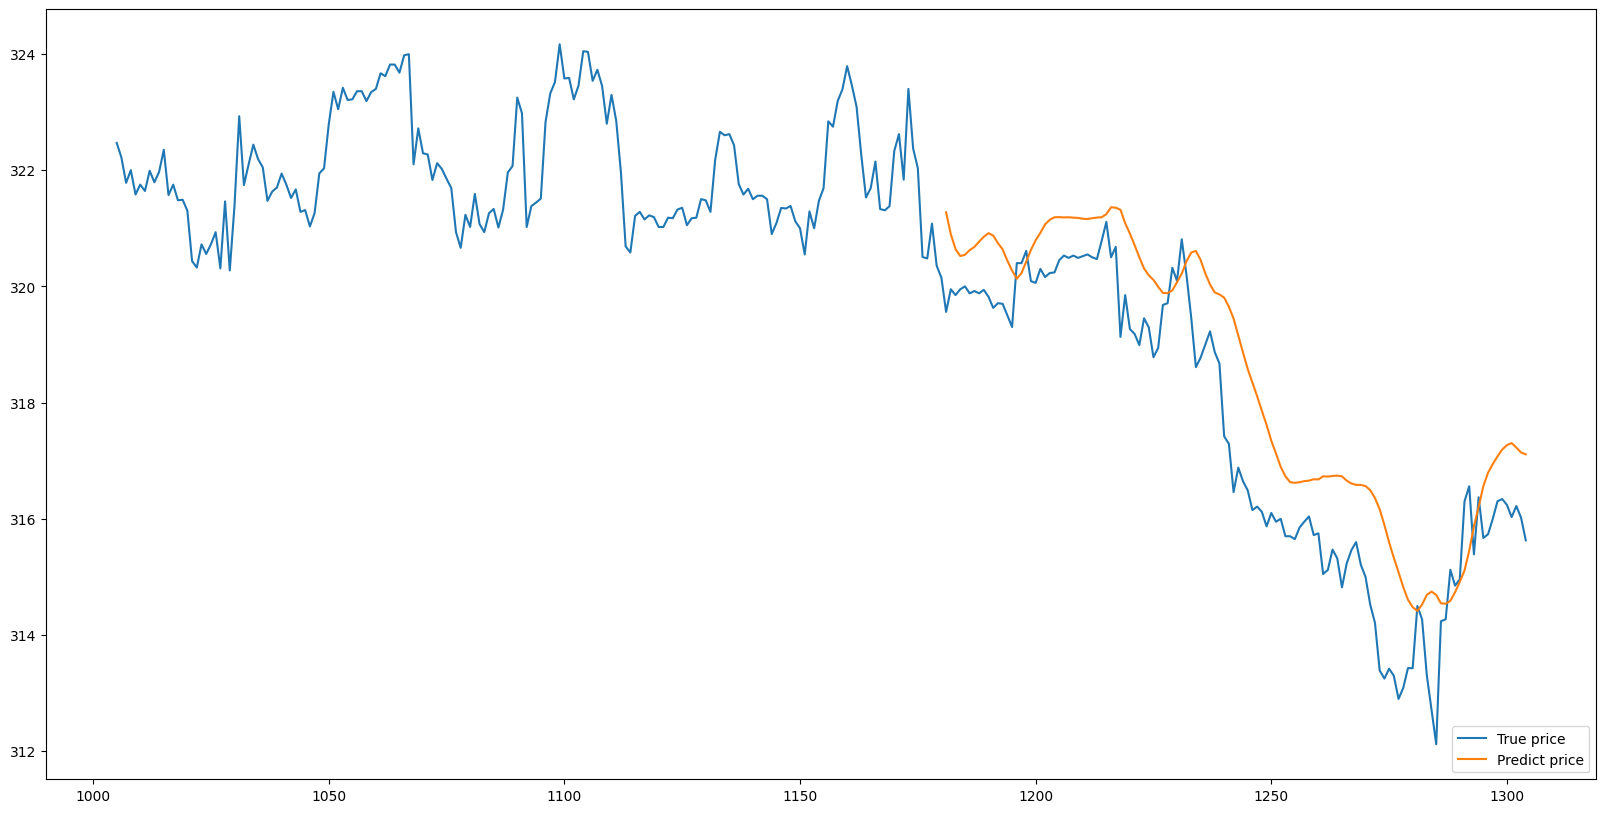

In [51]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_ROC_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_ROC_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI + SMA

Epoch 1/20
32/32 [==============================] - 8s 89ms/step - loss: 0.0265 - val_loss: 0.0029
Epoch 2/20
32/32 [==============================] - 2s 51ms/step - loss: 0.0029 - val_loss: 8.5733e-04
Epoch 3/20
32/32 [==============================] - 2s 52ms/step - loss: 0.0016 - val_loss: 5.5754e-04
Epoch 4/20
32/32 [==============================] - 2s 52ms/step - loss: 0.0012 - val_loss: 7.5205e-04
Epoch 5/20
32/32 [==============================] - 2s 52ms/step - loss: 0.0012 - val_loss: 6.3499e-04
Epoch 6/20
32/32 [==============================] - 2s 55ms/step - loss: 0.0010 - val_loss: 6.5579e-04
Epoch 7/20
32/32 [==============================] - 2s 57ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 8/20
32/32 [==============================] - 2s 53ms/step - loss: 0.0012 - val_loss: 5.5709e-04
Epoch 9/20
32/32 [==============================] - 2s 56ms/step - loss: 9.9315e-04 - val_loss: 7.6061e-04
Epoch 10/20
32/32 [==============================] - 2s 56ms/step - loss: 9.3

C:\Users\lonel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 1s 19ms/step


C:\Users\lonel\AppData\Local\Temp\ipykernel_6528\2788306312.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


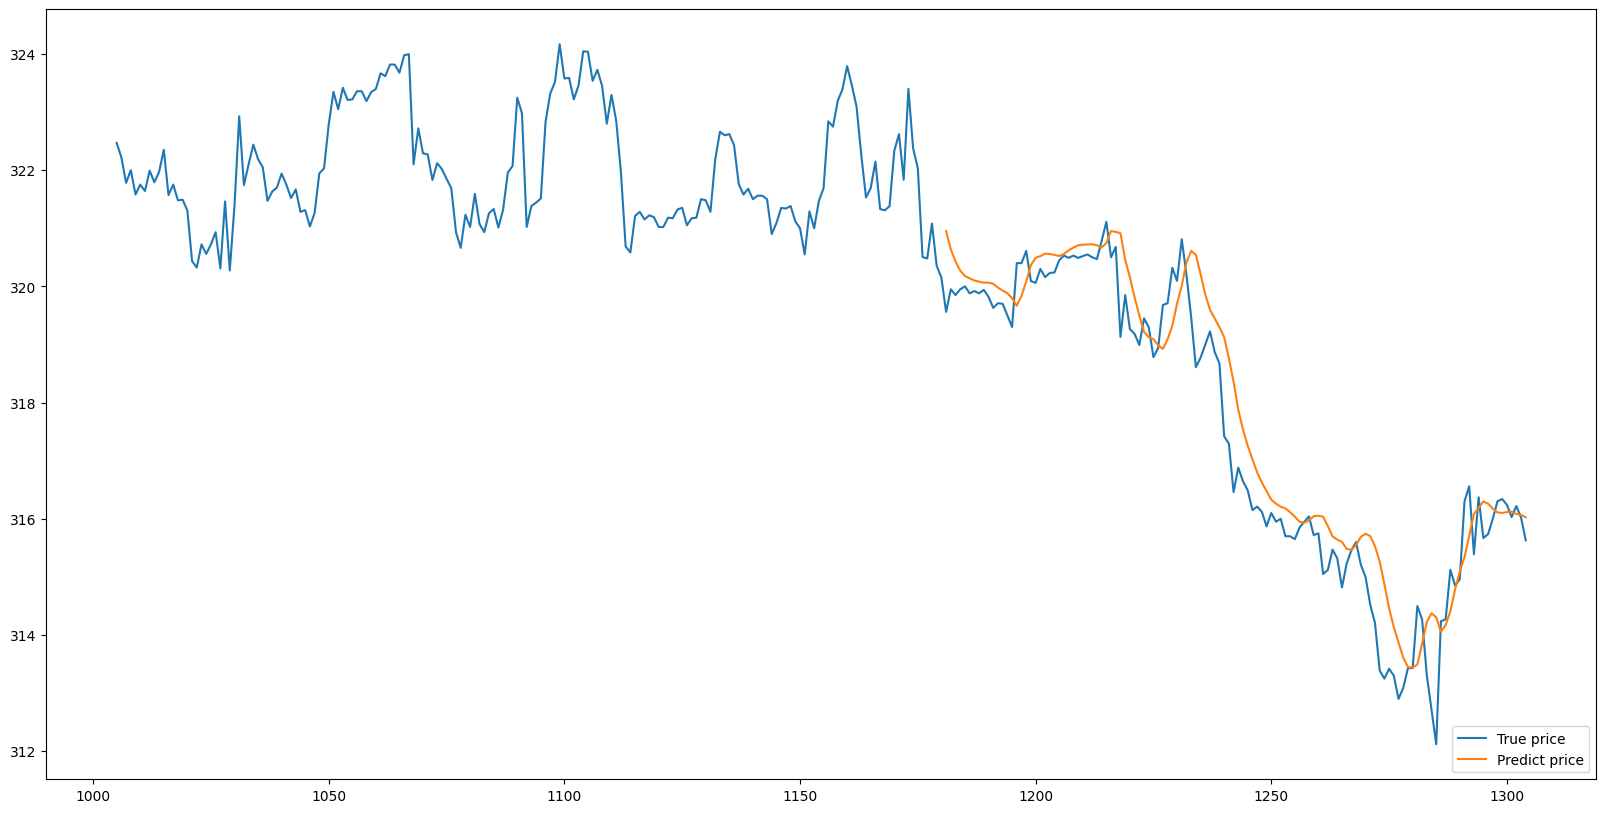

In [52]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_RSI_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_RSI_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI

Epoch 1/20
32/32 [==============================] - 9s 110ms/step - loss: 0.0178 - val_loss: 7.2996e-04
Epoch 2/20
32/32 [==============================] - 2s 58ms/step - loss: 0.0018 - val_loss: 8.4794e-04
Epoch 3/20
32/32 [==============================] - 2s 54ms/step - loss: 0.0012 - val_loss: 6.2307e-04
Epoch 4/20
32/32 [==============================] - 2s 55ms/step - loss: 0.0012 - val_loss: 6.1707e-04
Epoch 5/20
32/32 [==============================] - 2s 52ms/step - loss: 9.3742e-04 - val_loss: 8.2858e-04
Epoch 6/20
32/32 [==============================] - 2s 53ms/step - loss: 9.7977e-04 - val_loss: 4.4984e-04
Epoch 7/20
32/32 [==============================] - 2s 60ms/step - loss: 8.5526e-04 - val_loss: 4.5013e-04
Epoch 8/20
32/32 [==============================] - 2s 62ms/step - loss: 8.3066e-04 - val_loss: 3.9585e-04
Epoch 9/20
32/32 [==============================] - 2s 55ms/step - loss: 8.1686e-04 - val_loss: 4.5222e-04
Epoch 10/20
32/32 [==============================] -

C:\Users\lonel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 1s 20ms/step


C:\Users\lonel\AppData\Local\Temp\ipykernel_6528\1830590247.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


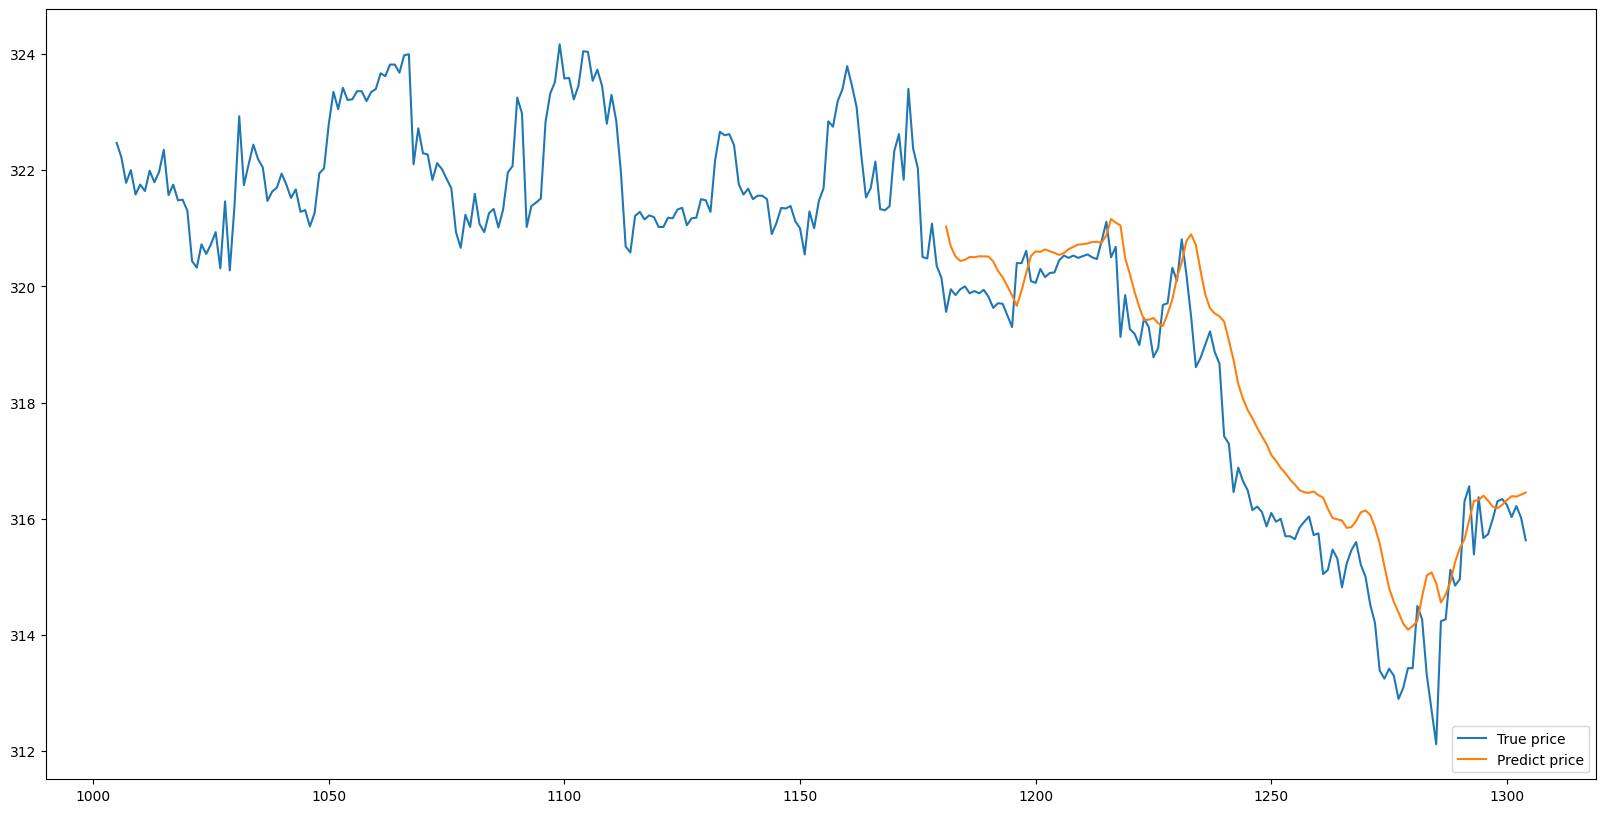

In [53]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_ROC_RSI.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_ROC_RSI.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + SMA

Epoch 1/20
32/32 [==============================] - 8s 91ms/step - loss: 0.0161 - val_loss: 8.8258e-04
Epoch 2/20
32/32 [==============================] - 2s 56ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 3/20
32/32 [==============================] - 2s 60ms/step - loss: 0.0018 - val_loss: 6.8650e-04
Epoch 4/20
32/32 [==============================] - 2s 65ms/step - loss: 0.0014 - val_loss: 6.9928e-04
Epoch 5/20
32/32 [==============================] - 2s 52ms/step - loss: 0.0015 - val_loss: 6.6621e-04
Epoch 6/20
32/32 [==============================] - 2s 55ms/step - loss: 0.0014 - val_loss: 9.3009e-04
Epoch 7/20
32/32 [==============================] - 2s 53ms/step - loss: 0.0013 - val_loss: 6.5956e-04
Epoch 8/20
32/32 [==============================] - 2s 55ms/step - loss: 0.0012 - val_loss: 7.0606e-04
Epoch 9/20
32/32 [==============================] - 2s 53ms/step - loss: 0.0011 - val_loss: 9.4294e-04
Epoch 10/20
32/32 [==============================] - 2s 52ms/step - loss: 0.0

C:\Users\lonel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 1s 18ms/step


C:\Users\lonel\AppData\Local\Temp\ipykernel_6528\2869371903.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


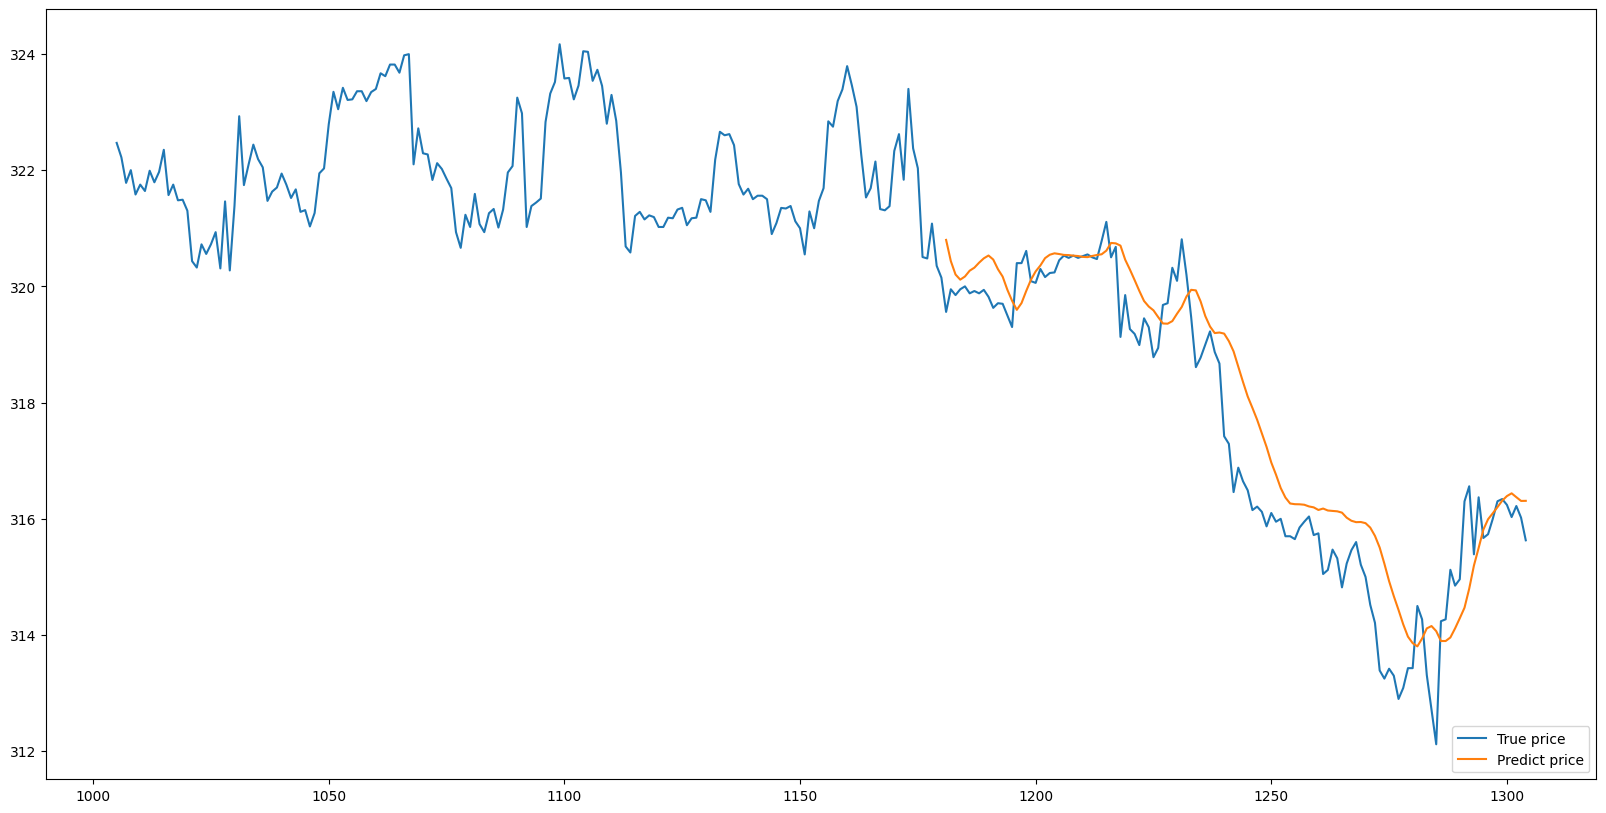

In [54]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_ROC_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_ROC_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI + SMA

Epoch 1/20
32/32 [==============================] - 9s 89ms/step - loss: 0.0210 - val_loss: 8.9869e-04
Epoch 2/20
32/32 [==============================] - 2s 53ms/step - loss: 0.0032 - val_loss: 7.1245e-04
Epoch 3/20
32/32 [==============================] - 2s 52ms/step - loss: 0.0016 - val_loss: 5.4089e-04
Epoch 4/20
32/32 [==============================] - 2s 53ms/step - loss: 0.0012 - val_loss: 5.5274e-04
Epoch 5/20
32/32 [==============================] - 2s 57ms/step - loss: 0.0011 - val_loss: 5.5183e-04
Epoch 6/20
32/32 [==============================] - 2s 64ms/step - loss: 0.0011 - val_loss: 5.6747e-04
Epoch 7/20
32/32 [==============================] - 2s 53ms/step - loss: 9.8060e-04 - val_loss: 4.9944e-04
Epoch 8/20
32/32 [==============================] - 2s 53ms/step - loss: 9.2527e-04 - val_loss: 5.5548e-04
Epoch 9/20
32/32 [==============================] - 2s 54ms/step - loss: 9.1830e-04 - val_loss: 4.4669e-04
Epoch 10/20
32/32 [==============================] - 2s 52ms/

C:\Users\lonel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 1s 26ms/step


C:\Users\lonel\AppData\Local\Temp\ipykernel_6528\3151824730.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


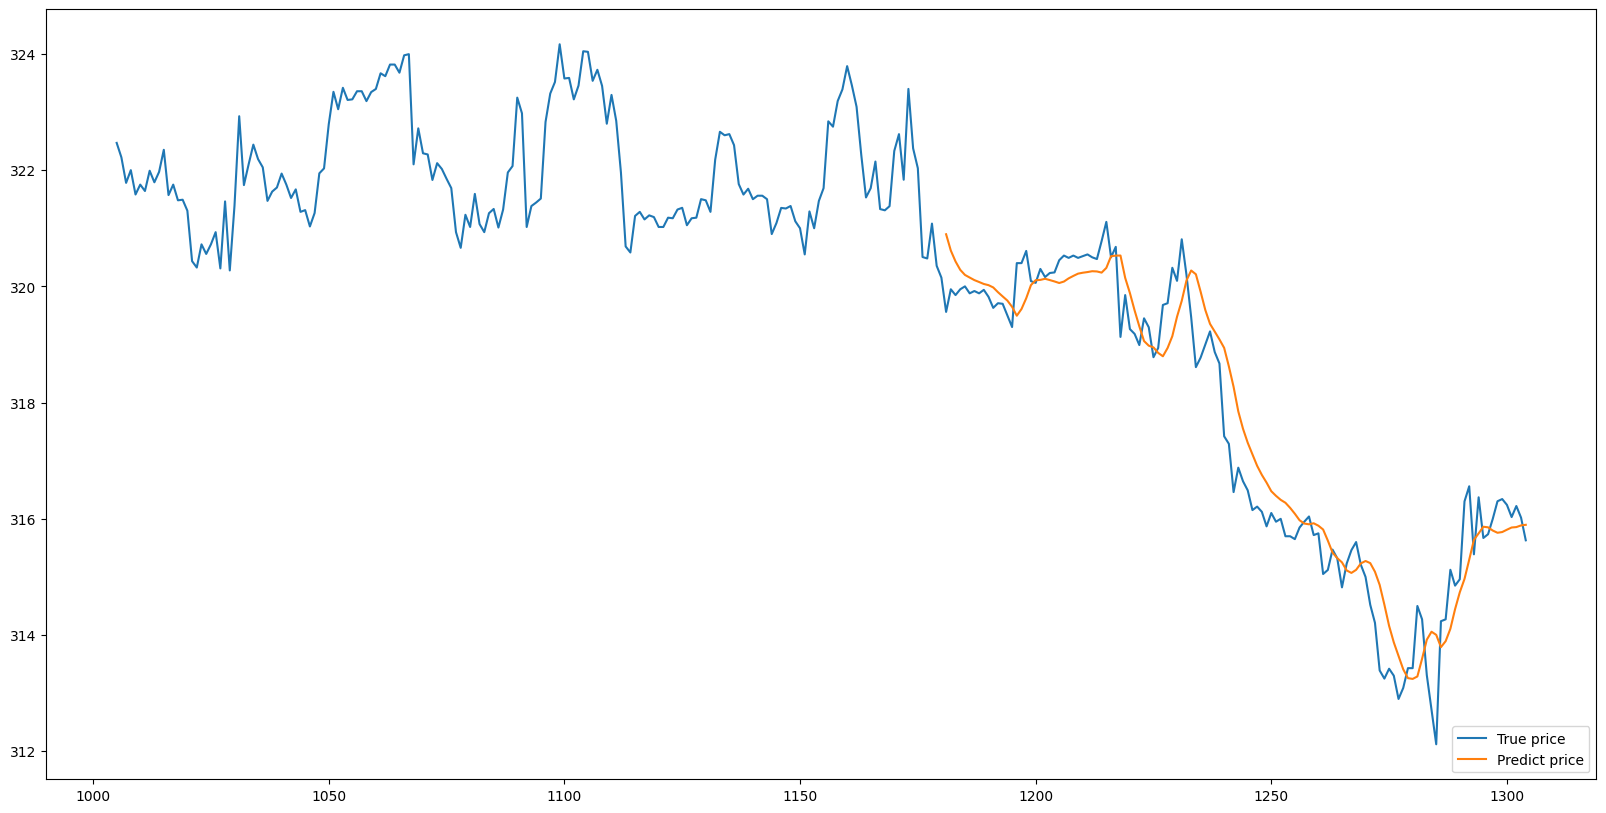

In [55]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_RSI_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_RSI_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI + SMA

Epoch 1/20
32/32 [==============================] - 9s 86ms/step - loss: 0.0210 - val_loss: 8.5859e-04
Epoch 2/20
32/32 [==============================] - 2s 50ms/step - loss: 0.0017 - val_loss: 6.1483e-04
Epoch 3/20
32/32 [==============================] - 2s 53ms/step - loss: 0.0014 - val_loss: 6.2001e-04
Epoch 4/20
32/32 [==============================] - 2s 50ms/step - loss: 0.0011 - val_loss: 8.3141e-04
Epoch 5/20
32/32 [==============================] - 2s 59ms/step - loss: 0.0010 - val_loss: 6.7548e-04
Epoch 6/20
32/32 [==============================] - 2s 53ms/step - loss: 9.9179e-04 - val_loss: 5.1461e-04
Epoch 7/20
32/32 [==============================] - 2s 56ms/step - loss: 0.0010 - val_loss: 4.8835e-04
Epoch 8/20
32/32 [==============================] - 2s 55ms/step - loss: 0.0010 - val_loss: 4.9143e-04
Epoch 9/20
32/32 [==============================] - 2s 51ms/step - loss: 0.0011 - val_loss: 4.4999e-04
Epoch 10/20
32/32 [==============================] - 2s 52ms/step - l

C:\Users\lonel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 2s 26ms/step


C:\Users\lonel\AppData\Local\Temp\ipykernel_6528\966894094.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


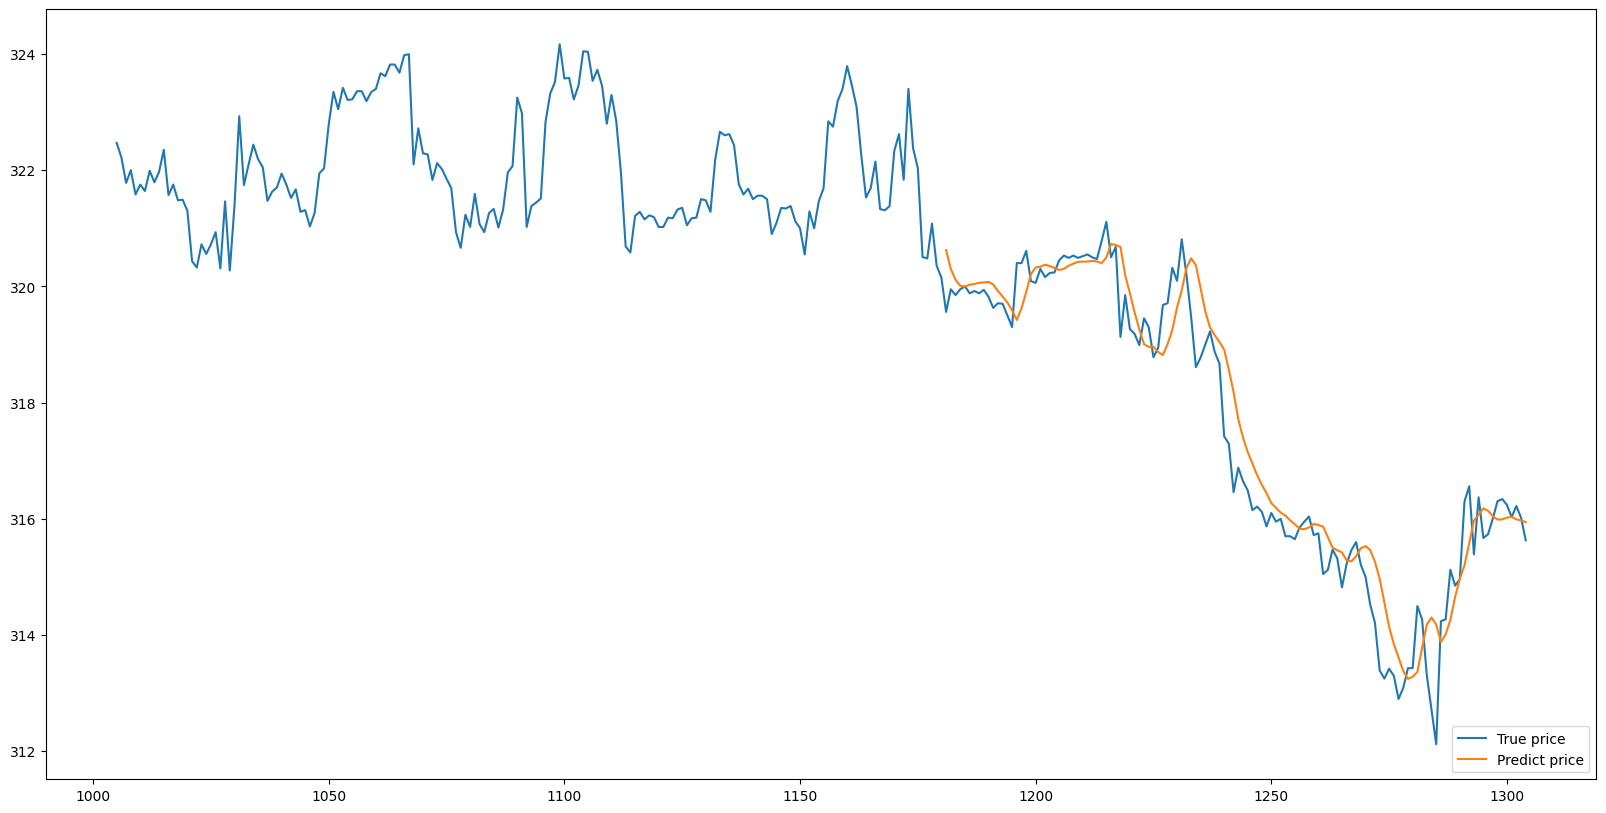

In [56]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_ROC_RSI_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_ROC_RSI_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI + SMA

Epoch 1/20
32/32 [==============================] - 21s 119ms/step - loss: 0.0312 - val_loss: 6.3898e-04
Epoch 2/20
32/32 [==============================] - 2s 70ms/step - loss: 0.0026 - val_loss: 6.8195e-04
Epoch 3/20
32/32 [==============================] - 2s 63ms/step - loss: 0.0014 - val_loss: 5.6217e-04
Epoch 4/20
32/32 [==============================] - 2s 75ms/step - loss: 0.0012 - val_loss: 5.7043e-04
Epoch 5/20
32/32 [==============================] - 2s 70ms/step - loss: 0.0010 - val_loss: 7.1326e-04
Epoch 6/20
32/32 [==============================] - 2s 66ms/step - loss: 0.0010 - val_loss: 5.5595e-04
Epoch 7/20
32/32 [==============================] - 2s 62ms/step - loss: 9.3152e-04 - val_loss: 5.1490e-04
Epoch 8/20
32/32 [==============================] - 3s 95ms/step - loss: 8.7858e-04 - val_loss: 5.4742e-04
Epoch 9/20
32/32 [==============================] - 3s 88ms/step - loss: 0.0010 - val_loss: 4.4230e-04
Epoch 10/20
32/32 [==============================] - 3s 108ms/s

C:\Users\lonel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 2s 20ms/step


C:\Users\lonel\AppData\Local\Temp\ipykernel_6528\527665821.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


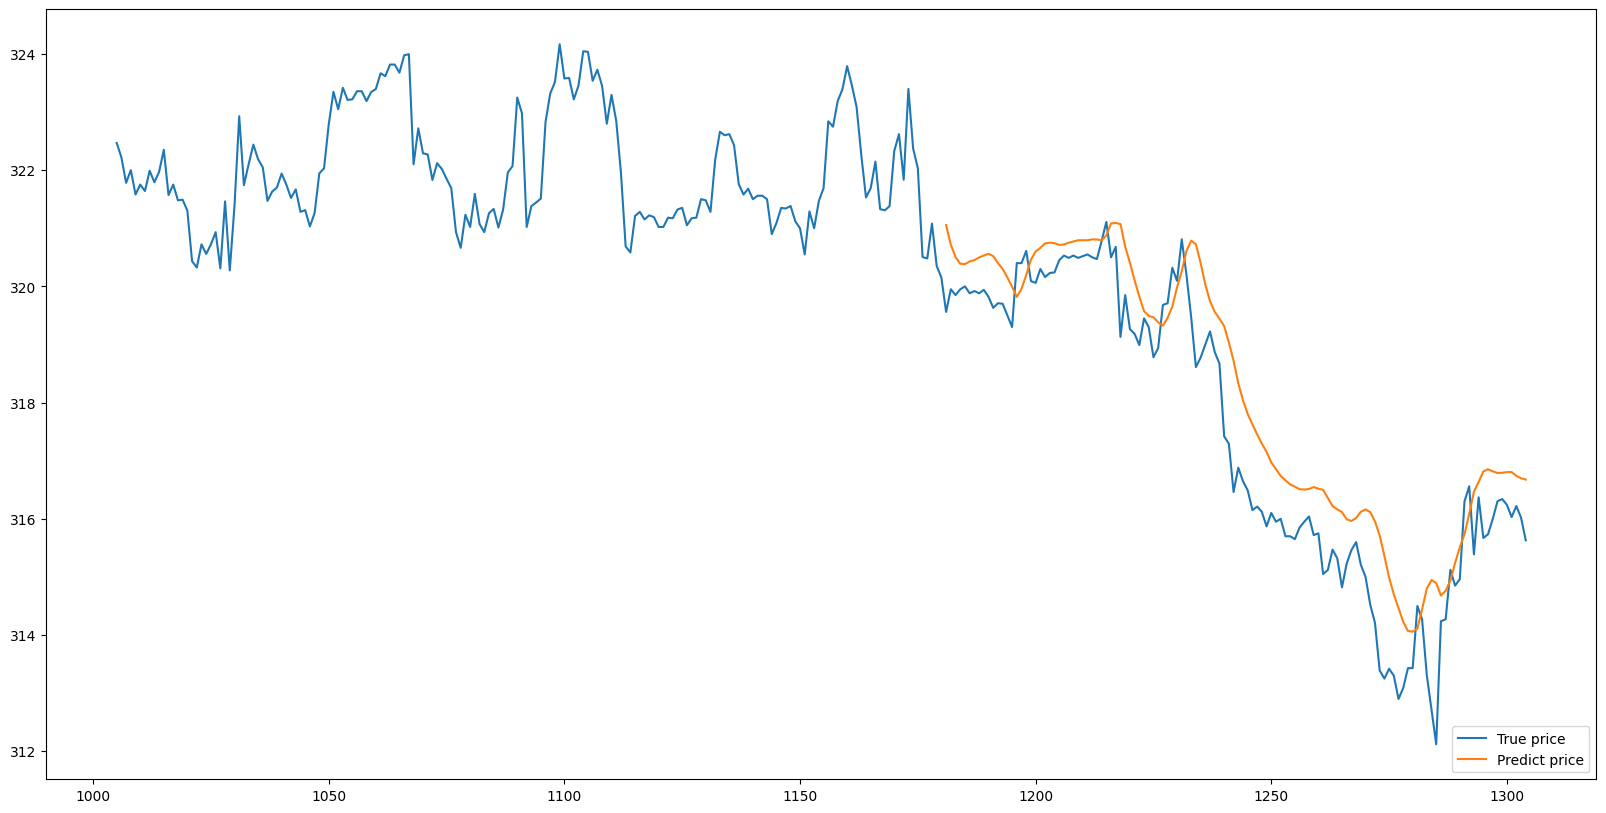

In [57]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_ROC_RSI_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_ROC_RSI_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### e. Predict Future

In [58]:
def lstm_predict_future(data, modelName, indicatorArr, period):
    modelFileName = './MODEL/' + modelName
    sorted(indicatorArr)
    for indicator in indicatorArr:
        if indicator == 'close':
            continue
        modelFileName = modelFileName + '_' + indicator
    modelFileName = modelFileName + '.h5'
    model = load_model(modelFileName)
    numDataPoint = int(period / 15)
    
    data = data[indicatorArr].values
    data = data[-60:]

    scaler = MinMaxScaler(feature_range=(0,1))
    scaledData = scaler.fit_transform(data)

    modelInput = scaledData.reshape(-1, scaledData.shape[0], scaledData.shape[1])

    predictedScaledValue = model.predict(modelInput)

    predictedValue = scaler.inverse_transform(np.tile(predictedScaledValue, (1, scaledData.shape[1])))[:, 0]
    
    return predictedValue

## 3. XGBOOST

### a. Prepare input

In [99]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume']]
dataset

,close,volume
0,348.894,36667.0
1,348.455,85578.0
2,348.724,3084021.0
3,346.933,1315197.0
4,346.808,1187090.0
...,...,...
1300,316.240,328438.0
1301,316.030,257911.0
1302,316.220,386415.0
1303,316.020,313136.0


In [101]:
for i in range (1, 3):
    dataset.loc[:, "close_date_" + str(i)] = dataset.close.shift(i)
    dataset.loc[:, "volume_date_" + str(i)] = dataset.volume.shift(i)
dataset

,close,volume,close_date_1,volume_date_1,close_date_2,volume_date_2
0,348.894,36667.0,NaN,NaN,NaN,NaN
1,348.455,85578.0,348.894,36667.0,NaN,NaN
2,348.724,3084021.0,348.455,85578.0,348.894,36667.0
3,346.933,1315197.0,348.724,3084021.0,348.455,85578.0
4,346.808,1187090.0,346.933,1315197.0,348.724,3084021.0
...,...,...,...,...,...,...
1300,316.240,328438.0,316.340,477819.0,316.302,417452.0
1301,316.030,257911.0,316.240,328438.0,316.340,477819.0
1302,316.220,386415.0,316.030,257911.0,316.240,328438.0
1303,316.020,313136.0,316.220,386415.0,316.030,257911.0


In [102]:
dataset = dataset.dropna()
dataset

,close,volume,close_date_1,volume_date_1,close_date_2,volume_date_2
2,348.724,3084021.0,348.455,85578.0,348.894,36667.0
3,346.933,1315197.0,348.724,3084021.0,348.455,85578.0
4,346.808,1187090.0,346.933,1315197.0,348.724,3084021.0
5,345.436,1126829.0,346.808,1187090.0,346.933,1315197.0
6,346.258,1003648.0,345.436,1126829.0,346.808,1187090.0
...,...,...,...,...,...,...
1300,316.240,328438.0,316.340,477819.0,316.302,417452.0
1301,316.030,257911.0,316.240,328438.0,316.340,477819.0
1302,316.220,386415.0,316.030,257911.0,316.240,328438.0
1303,316.020,313136.0,316.220,386415.0,316.030,257911.0


In [103]:
X = dataset.drop(['close', 'volume'], axis=1)
y = pd.DataFrame(dataset['close'])
print(X.shape)
print(y.shape)
X

(1303, 4)
(1303, 1)


,close_date_1,volume_date_1,close_date_2,volume_date_2
2,348.455,85578.0,348.894,36667.0
3,348.724,3084021.0,348.455,85578.0
4,346.933,1315197.0,348.724,3084021.0
5,346.808,1187090.0,346.933,1315197.0
6,345.436,1126829.0,346.808,1187090.0
...,...,...,...,...
1300,316.340,477819.0,316.302,417452.0
1301,316.240,328438.0,316.340,477819.0
1302,316.030,257911.0,316.240,328438.0
1303,316.220,386415.0,316.030,257911.0


In [104]:
X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]
print("Size train: ", X_train.shape)
print("Size test: ", X_test.shape)

Size train:  (1173, 4)
Size test:  (130, 4)


### b. Train Model

In [105]:
xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST.dat", "wb"))

### c. Test Model

In [106]:
model_xgboost = pickle.load(open("./MODEL/XGBOOST.dat", "rb"))

In [107]:
predictions = model_xgboost.predict(X_test)
predictions

array([323.1016 , 322.26334, 320.62885, 320.2604 , 320.77023, 320.5129 ,
       320.41708, 320.08038, 320.3453 , 320.4047 , 320.09808, 320.38397,
       320.4641 , 320.44308, 320.31525, 320.41873, 320.4996 , 320.37146,
       320.42944, 320.42795, 320.35614, 320.38324, 320.3774 , 320.30273,
       320.50372, 320.44308, 320.4627 , 320.41647, 320.41647, 320.41647,
       320.49234, 320.30994, 320.24326, 320.4893 , 320.31525, 320.28357,
       320.31122, 320.4615 , 320.263  , 320.41864, 320.6242 , 321.10904,
       320.25   , 320.51492, 320.15213, 320.37692, 320.4013 , 320.44647,
       320.3722 , 320.25018, 320.33405, 320.21982, 320.21982, 320.397  ,
       320.25006, 320.11847, 320.25684, 320.37057, 320.23727, 319.95102,
       320.24554, 320.2137 , 320.32632, 320.4947 , 320.29617, 320.33368,
       320.3321 , 320.4887 , 320.81842, 320.3351 , 320.2521 , 320.23566,
       320.45676, 320.52606, 319.90234, 320.56305, 320.4418 , 320.35358,
       320.27142, 320.38324, 320.3838 , 320.33417, 

In [108]:
prediction_df = dataset.iloc[-len(predictions):].copy()
prediction_df['predictions'] = predictions
prediction_df

,close,volume,close_date_1,volume_date_1,close_date_2,volume_date_2,predictions
1175,322.033,358888.0,322.375,393013.0,323.398,513453.0,323.101593
1176,320.505,542231.0,322.033,358888.0,322.375,393013.0,322.263336
1177,320.480,434594.0,320.505,542231.0,322.033,358888.0,320.628845
1178,321.080,579123.0,320.480,434594.0,320.505,542231.0,320.260406
1179,320.353,1502382.0,321.080,579123.0,320.480,434594.0,320.770233
...,...,...,...,...,...,...,...
1300,316.240,328438.0,316.340,477819.0,316.302,417452.0,320.151001
1301,316.030,257911.0,316.240,328438.0,316.340,477819.0,320.182159
1302,316.220,386415.0,316.030,257911.0,316.240,328438.0,320.180573
1303,316.020,313136.0,316.220,386415.0,316.030,257911.0,320.112366


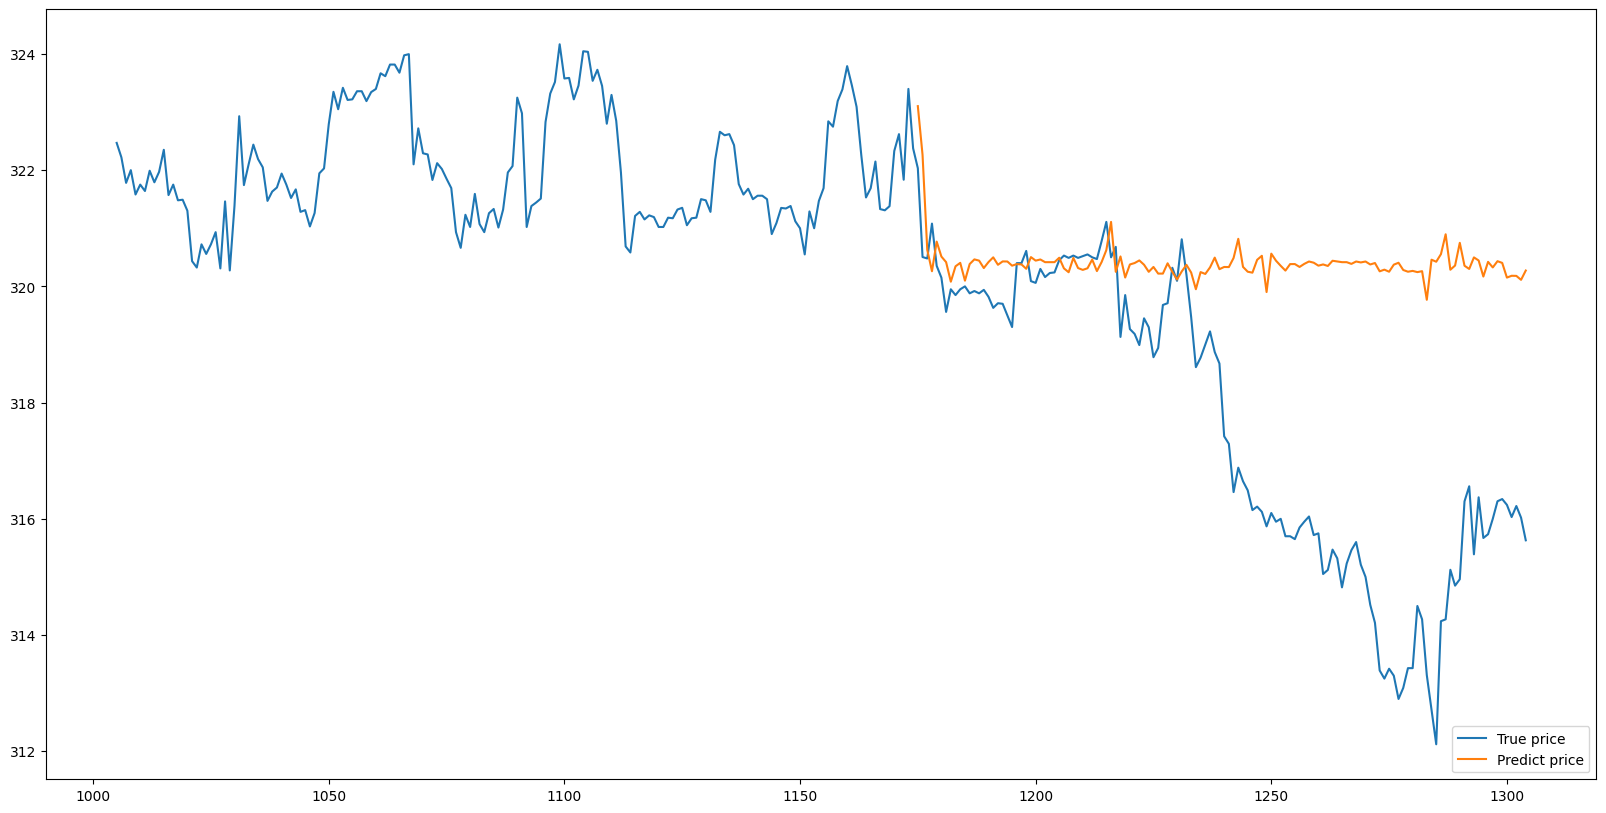

In [109]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### d. Combine Indicators

#### + ROC

In [115]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'ROC']]
dataset

,close,volume,ROC
0,348.894,36667.0,0.2840
1,348.455,85578.0,0.1434
2,348.724,3084021.0,0.1778
3,346.933,1315197.0,-0.2997
4,346.808,1187090.0,-0.3583
...,...,...,...
1300,316.240,328438.0,0.8965
1301,316.030,257911.0,0.4865
1302,316.220,386415.0,0.6205
1303,316.020,313136.0,0.8650


In [117]:
for i in range (1, 3):
    dataset.loc[:, "close_date_" + str(i)] = dataset.close.shift(i)
    dataset.loc[:, "volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset.loc[:, "ROC_date_" + str(i)] = dataset.ROC.shift(i)
dataset

,close,volume,ROC,close_date_1,volume_date_1,ROC_date_1,close_date_2,volume_date_2,ROC_date_2
0,348.894,36667.0,0.2840,NaN,NaN,NaN,NaN,NaN,NaN
1,348.455,85578.0,0.1434,348.894,36667.0,0.2840,NaN,NaN,NaN
2,348.724,3084021.0,0.1778,348.455,85578.0,0.1434,348.894,36667.0,0.2840
3,346.933,1315197.0,-0.2997,348.724,3084021.0,0.1778,348.455,85578.0,0.1434
4,346.808,1187090.0,-0.3583,346.933,1315197.0,-0.2997,348.724,3084021.0,0.1778
...,...,...,...,...,...,...,...,...,...
1300,316.240,328438.0,0.8965,316.340,477819.0,0.9284,316.302,417452.0,1.0259
1301,316.030,257911.0,0.4865,316.240,328438.0,0.8965,316.340,477819.0,0.9284
1302,316.220,386415.0,0.6205,316.030,257911.0,0.4865,316.240,328438.0,0.8965
1303,316.020,313136.0,0.8650,316.220,386415.0,0.6205,316.030,257911.0,0.4865


In [118]:
dataset = dataset.dropna()
dataset

,close,volume,ROC,close_date_1,volume_date_1,ROC_date_1,close_date_2,volume_date_2,ROC_date_2
2,348.724,3084021.0,0.1778,348.455,85578.0,0.1434,348.894,36667.0,0.2840
3,346.933,1315197.0,-0.2997,348.724,3084021.0,0.1778,348.455,85578.0,0.1434
4,346.808,1187090.0,-0.3583,346.933,1315197.0,-0.2997,348.724,3084021.0,0.1778
5,345.436,1126829.0,-0.7356,346.808,1187090.0,-0.3583,346.933,1315197.0,-0.2997
6,346.258,1003648.0,-0.4107,345.436,1126829.0,-0.7356,346.808,1187090.0,-0.3583
...,...,...,...,...,...,...,...,...,...
1300,316.240,328438.0,0.8965,316.340,477819.0,0.9284,316.302,417452.0,1.0259
1301,316.030,257911.0,0.4865,316.240,328438.0,0.8965,316.340,477819.0,0.9284
1302,316.220,386415.0,0.6205,316.030,257911.0,0.4865,316.240,328438.0,0.8965
1303,316.020,313136.0,0.8650,316.220,386415.0,0.6205,316.030,257911.0,0.4865


In [119]:
X = dataset.drop(['close', 'volume', 'ROC'], axis=1)
y = pd.DataFrame(dataset['close'])
print(X.shape)
print(y.shape)
X

(1303, 6)
(1303, 1)


,close_date_1,volume_date_1,ROC_date_1,close_date_2,volume_date_2,ROC_date_2
2,348.455,85578.0,0.1434,348.894,36667.0,0.2840
3,348.724,3084021.0,0.1778,348.455,85578.0,0.1434
4,346.933,1315197.0,-0.2997,348.724,3084021.0,0.1778
5,346.808,1187090.0,-0.3583,346.933,1315197.0,-0.2997
6,345.436,1126829.0,-0.7356,346.808,1187090.0,-0.3583
...,...,...,...,...,...,...
1300,316.340,477819.0,0.9284,316.302,417452.0,1.0259
1301,316.240,328438.0,0.8965,316.340,477819.0,0.9284
1302,316.030,257911.0,0.4865,316.240,328438.0,0.8965
1303,316.220,386415.0,0.6205,316.030,257911.0,0.4865


In [120]:
X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]
print("Size train: ", X_train.shape)
print("Size test: ", X_test.shape)

Size train:  (1173, 6)
Size test:  (130, 6)


In [126]:
xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_ROC.dat", "wb"))

In [127]:
model_xgboost = pickle.load(open("./MODEL/XGBOOST_ROC.dat", "rb"))

In [128]:
predictions = model_xgboost.predict(X_test)
predictions

array([322.58685, 321.97952, 320.33203, 320.2983 , 320.50552, 320.27924,
       320.5272 , 320.05756, 320.23227, 320.12967, 320.42523, 320.28143,
       320.51868, 320.51315, 320.45178, 320.36813, 320.4376 , 320.3933 ,
       320.3622 , 320.53793, 320.35522, 320.38498, 320.503  , 320.31888,
       320.7476 , 320.559  , 320.44644, 320.3373 , 320.39435, 320.3845 ,
       320.4227 , 320.41635, 320.29977, 320.16592, 320.40396, 320.45767,
       320.37646, 320.4079 , 320.14633, 320.11304, 320.34247, 321.02032,
       320.32468, 320.55774, 320.00635, 320.66092, 320.39   , 320.4311 ,
       320.70642, 320.43466, 320.32373, 319.9816 , 320.16214, 320.39655,
       320.23898, 320.3208 , 320.24042, 320.61914, 320.26935, 319.95584,
       320.04932, 320.15506, 320.22287, 320.30777, 320.40118, 320.24268,
       320.03104, 320.45667, 320.4941 , 320.23895, 320.25818, 320.2619 ,
       320.3568 , 320.47977, 320.28384, 320.16153, 320.24576, 320.43765,
       320.33994, 320.28806, 320.35986, 320.61227, 

In [129]:
prediction_df = dataset.iloc[-len(predictions):].copy()
prediction_df['predictions'] = predictions
prediction_df

,close,volume,ROC,close_date_1,volume_date_1,ROC_date_1,close_date_2,volume_date_2,ROC_date_2,predictions
1175,322.033,358888.0,0.1066,322.375,393013.0,0.2815,323.398,513453.0,0.7470,322.586853
1176,320.505,542231.0,-0.7233,322.033,358888.0,0.1066,322.375,393013.0,0.2815,321.979523
1177,320.480,434594.0,-0.7027,320.505,542231.0,-0.7233,322.033,358888.0,0.1066,320.332031
1178,321.080,579123.0,-0.6529,320.480,434594.0,-0.7027,320.505,542231.0,-0.7233,320.298309
1179,320.353,1502382.0,-0.9391,321.080,579123.0,-0.6529,320.480,434594.0,-0.7027,320.505524
...,...,...,...,...,...,...,...,...,...,...
1300,316.240,328438.0,0.8965,316.340,477819.0,0.9284,316.302,417452.0,1.0259,320.338531
1301,316.030,257911.0,0.4865,316.240,328438.0,0.8965,316.340,477819.0,0.9284,320.305206
1302,316.220,386415.0,0.6205,316.030,257911.0,0.4865,316.240,328438.0,0.8965,320.380341
1303,316.020,313136.0,0.8650,316.220,386415.0,0.6205,316.030,257911.0,0.4865,320.595154


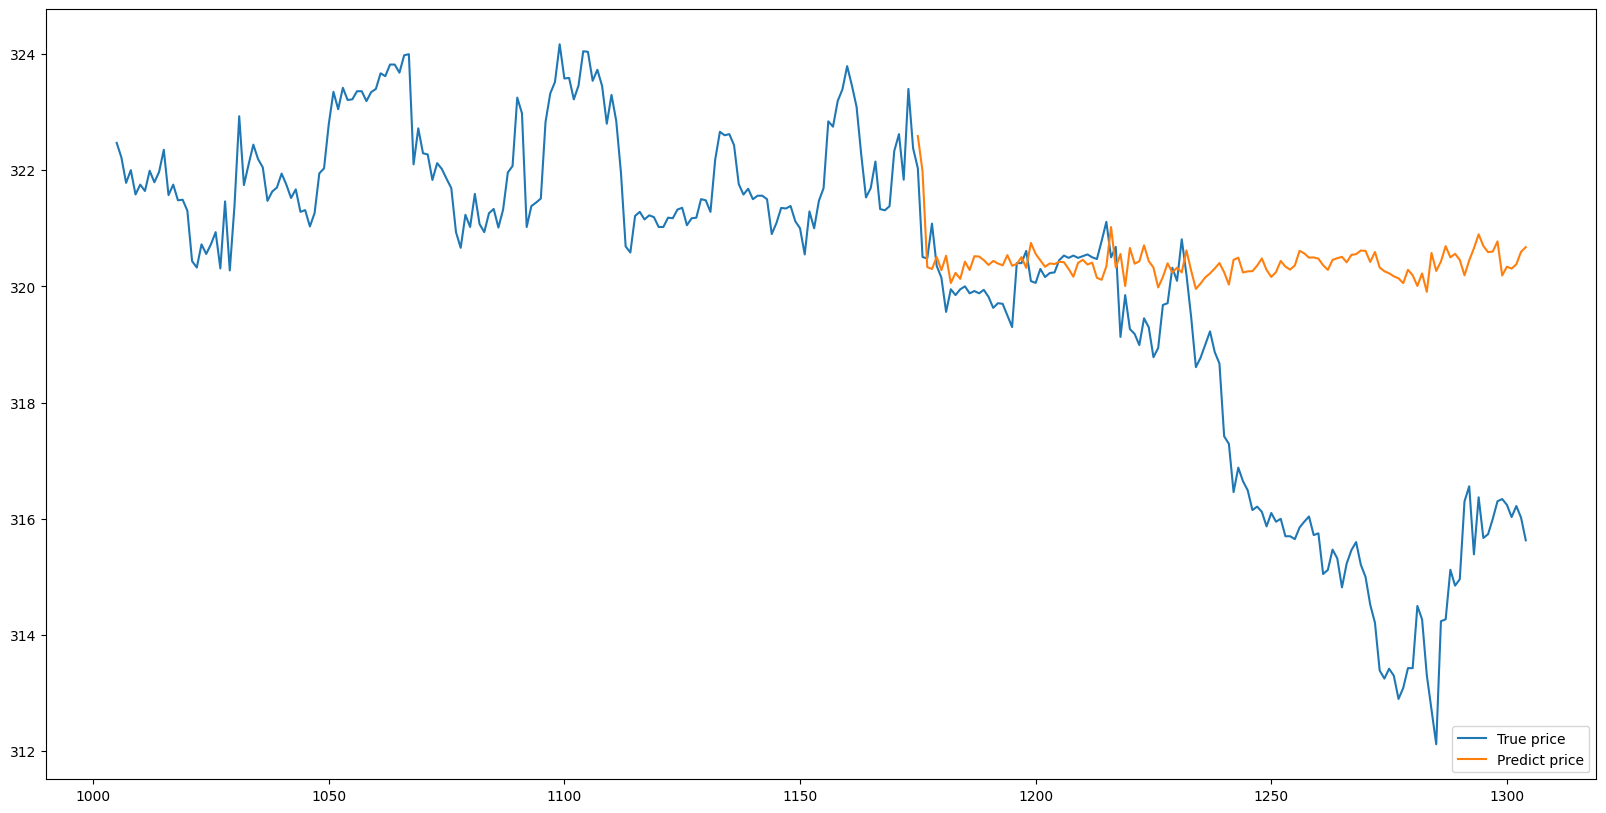

In [130]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### +SMA

C:\Users\lonel\AppData\Local\Temp\ipykernel_7644\3487119450.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.loc[:, "close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\lonel\AppData\Local\Temp\ipykernel_7644\3487119450.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.loc[:, "volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\lonel\AppData\Local\Temp\ipykernel_7644\3487119450.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


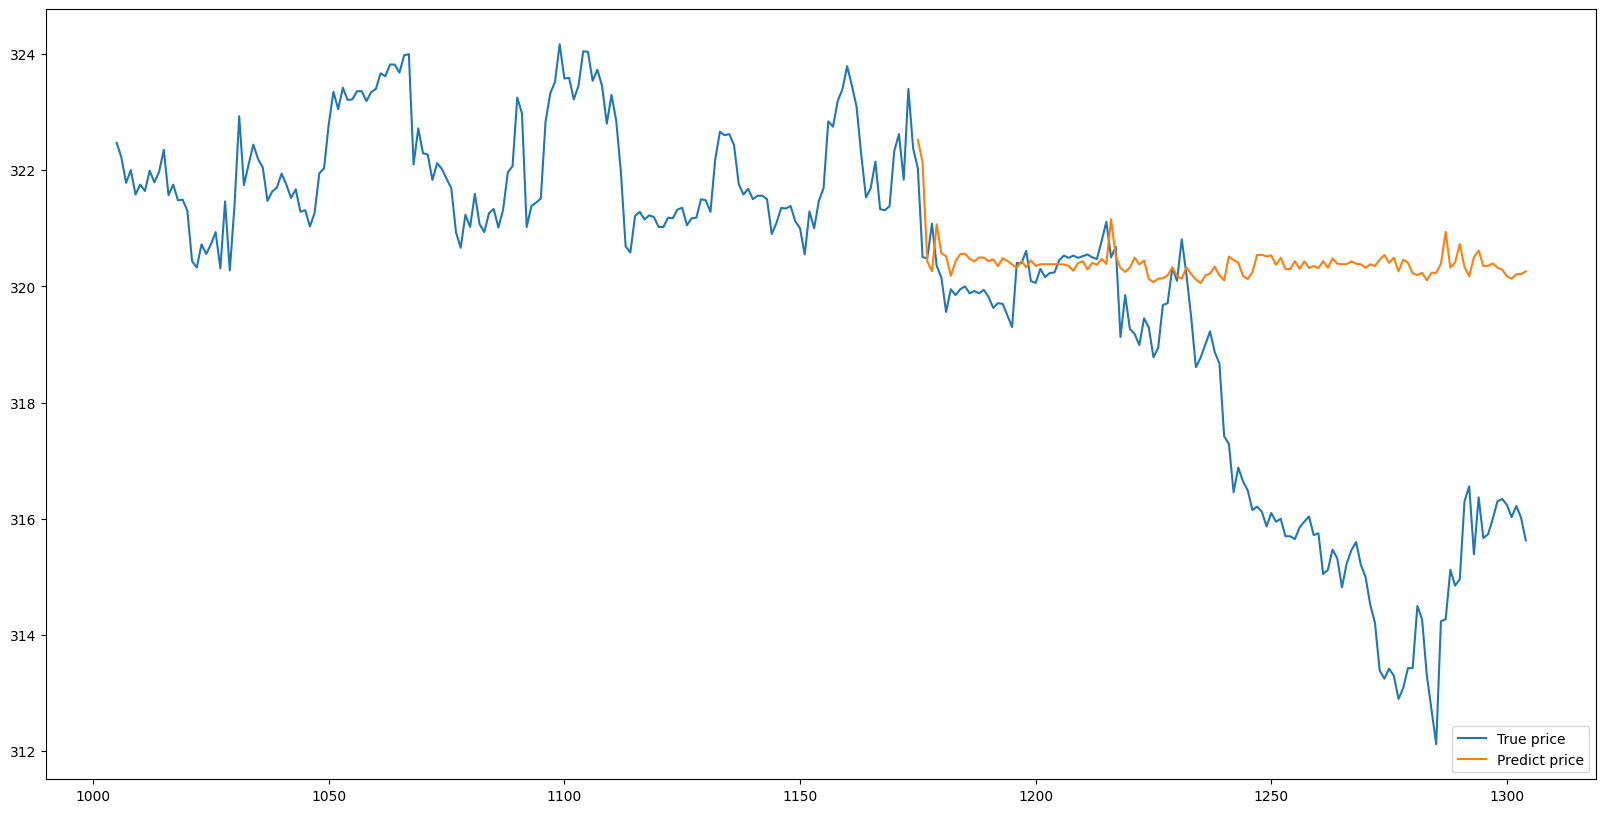

In [133]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'SMA']]

for i in range (1, 3):
    dataset.loc[:, "close_date_" + str(i)] = dataset.close.shift(i)
    dataset.loc[:, "volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset.loc[:, "SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset = dataset.dropna()

X = dataset.drop(['close', 'volume', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):].copy()
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI

C:\Users\lonel\AppData\Local\Temp\ipykernel_7644\599475182.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\lonel\AppData\Local\Temp\ipykernel_7644\599475182.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\lonel\AppData\Local\Temp\ipykernel_7644\599475182.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

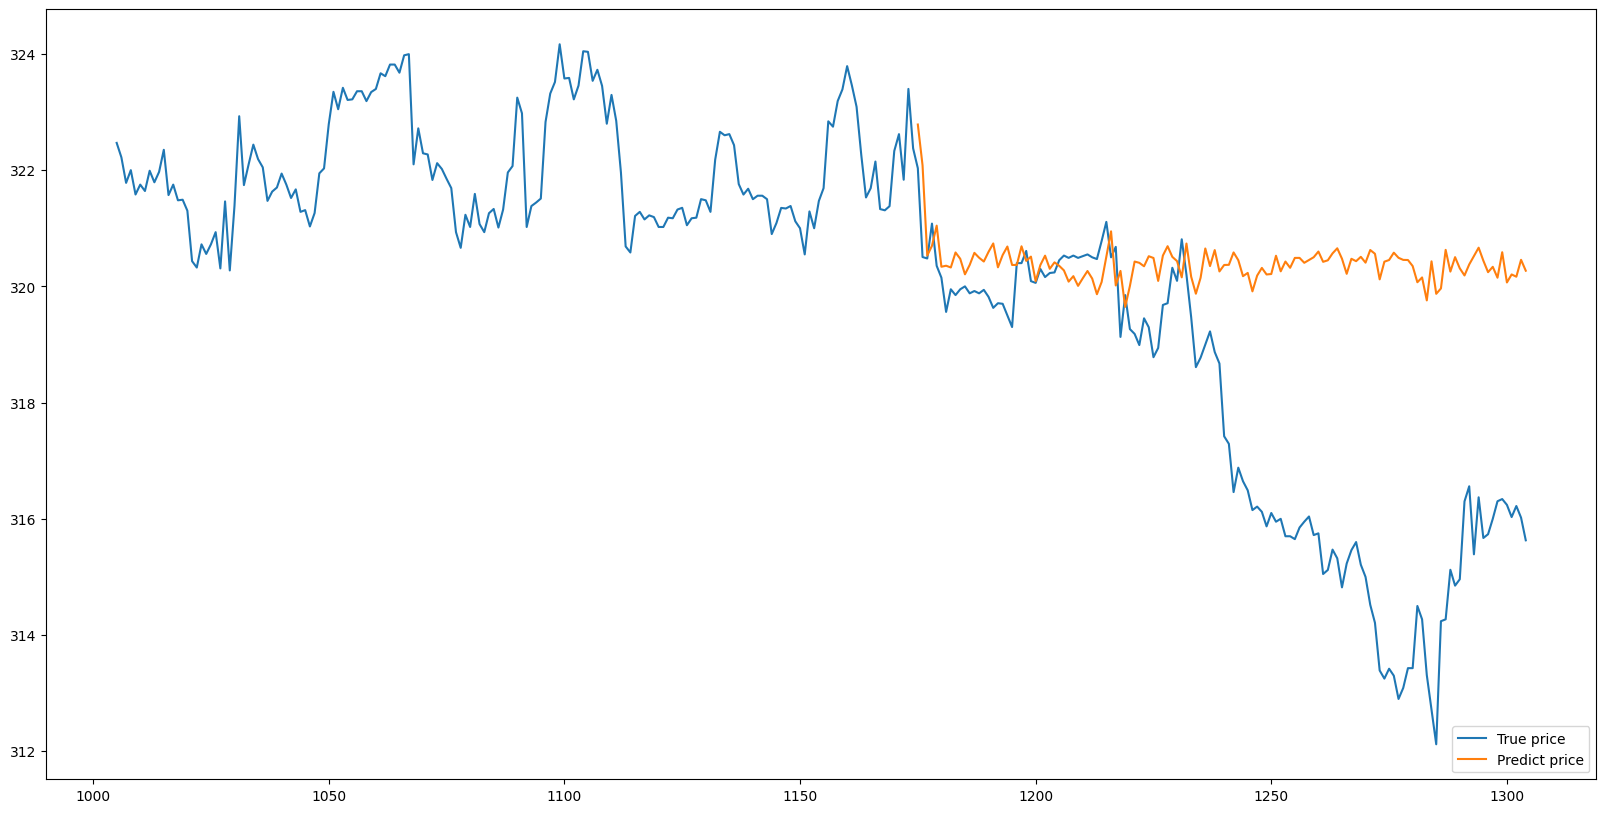

In [134]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS

C:\Users\lonel\AppData\Local\Temp\ipykernel_7644\4005043941.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\lonel\AppData\Local\Temp\ipykernel_7644\4005043941.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\lonel\AppData\Local\Temp\ipykernel_7644\4005043941.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

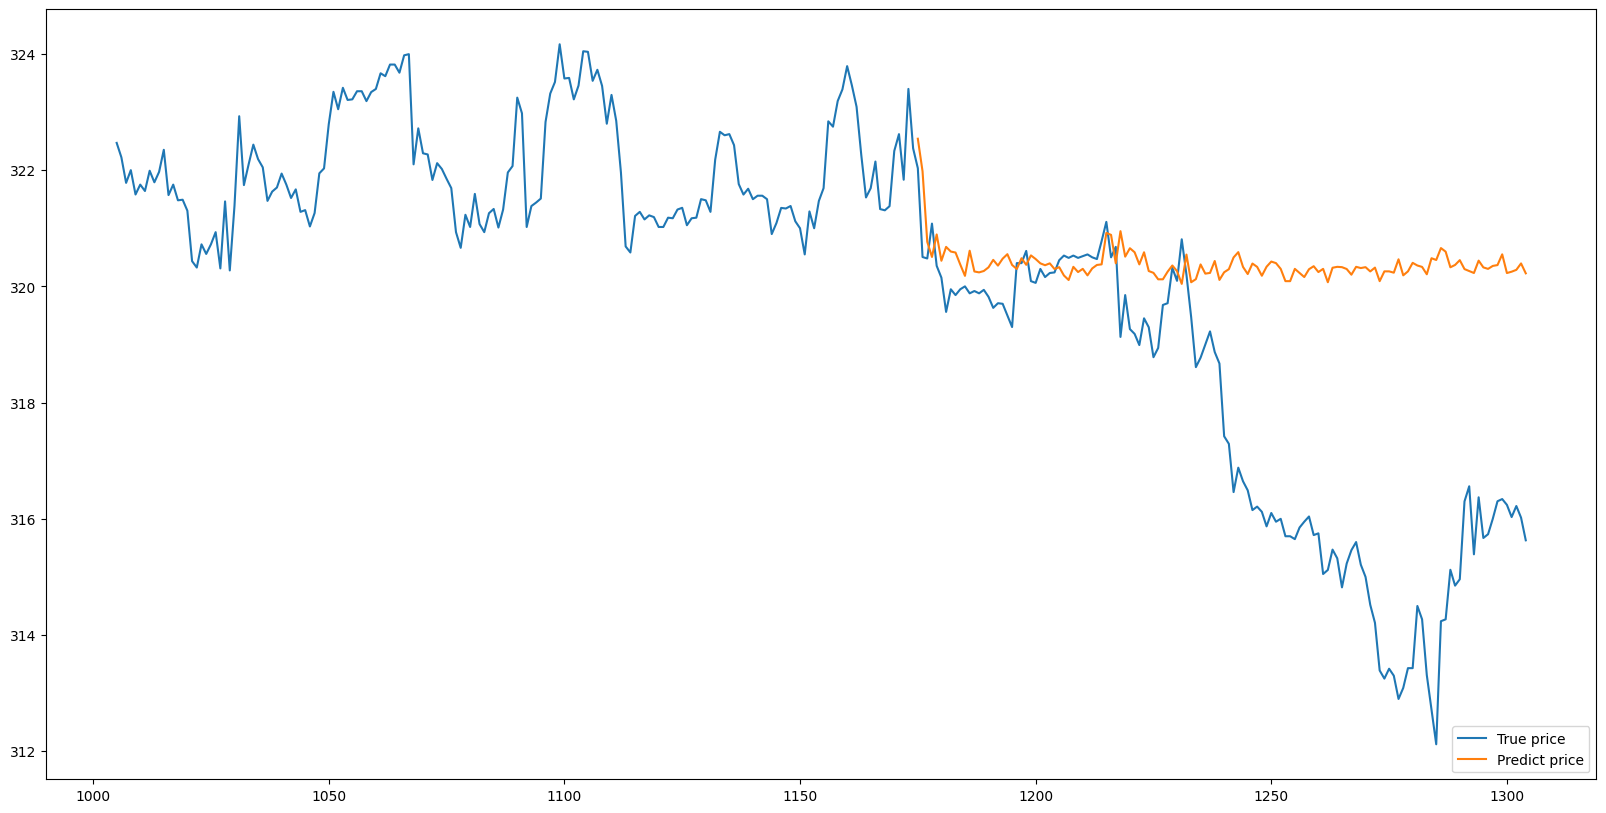

In [135]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)


dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC

C:\Users\lonel\AppData\Local\Temp\ipykernel_7644\4143684539.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\lonel\AppData\Local\Temp\ipykernel_7644\4143684539.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\lonel\AppData\Local\Temp\ipykernel_7644\4143684539.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

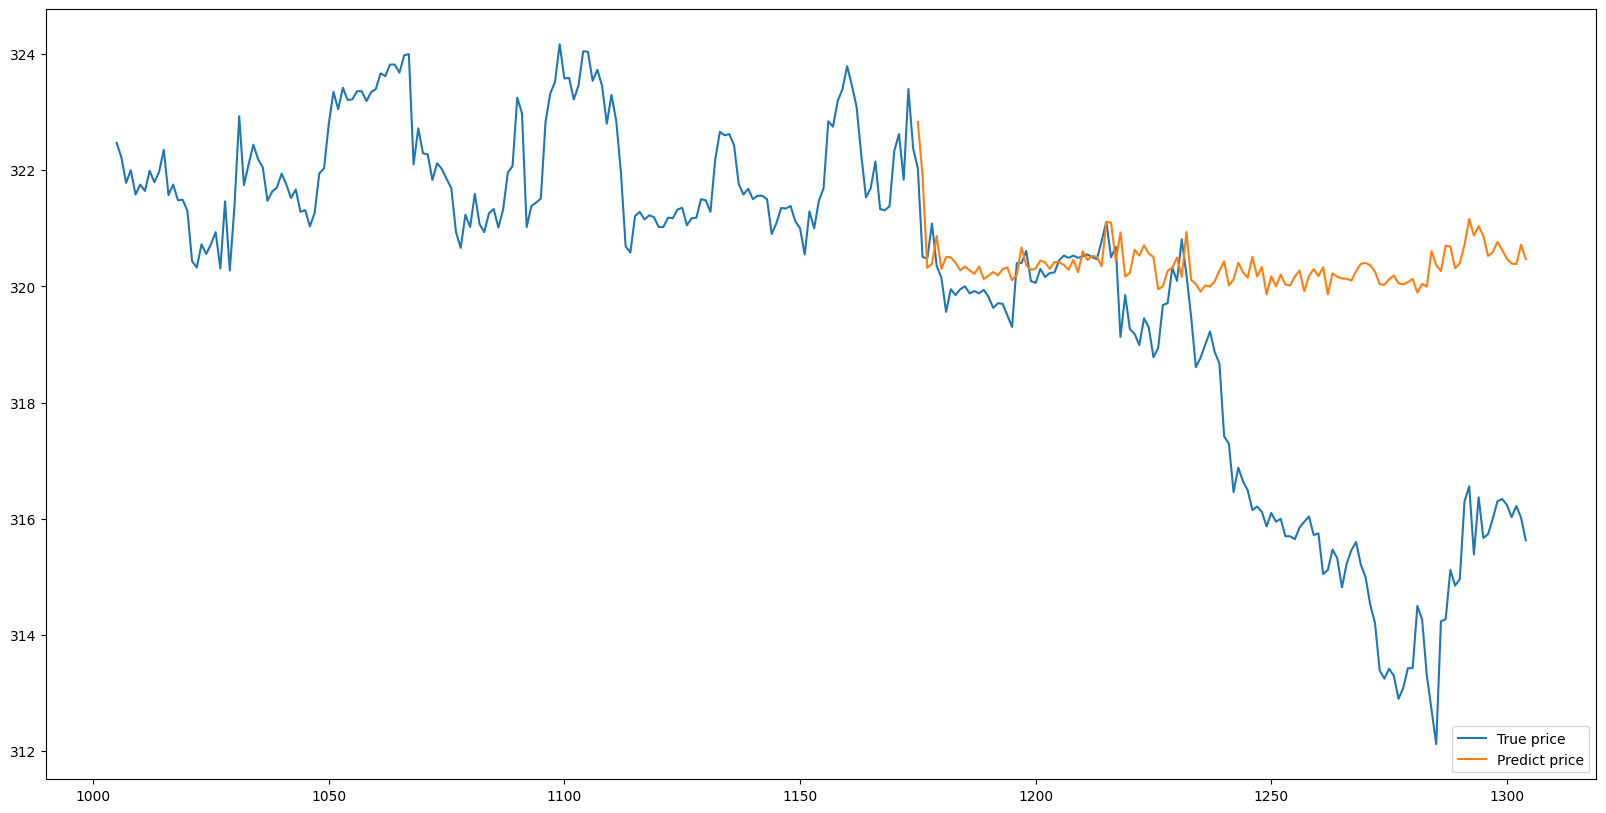

In [136]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_ROC.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_ROC.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI

C:\Users\lonel\AppData\Local\Temp\ipykernel_7644\371623579.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\lonel\AppData\Local\Temp\ipykernel_7644\371623579.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\lonel\AppData\Local\Temp\ipykernel_7644\371623579.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

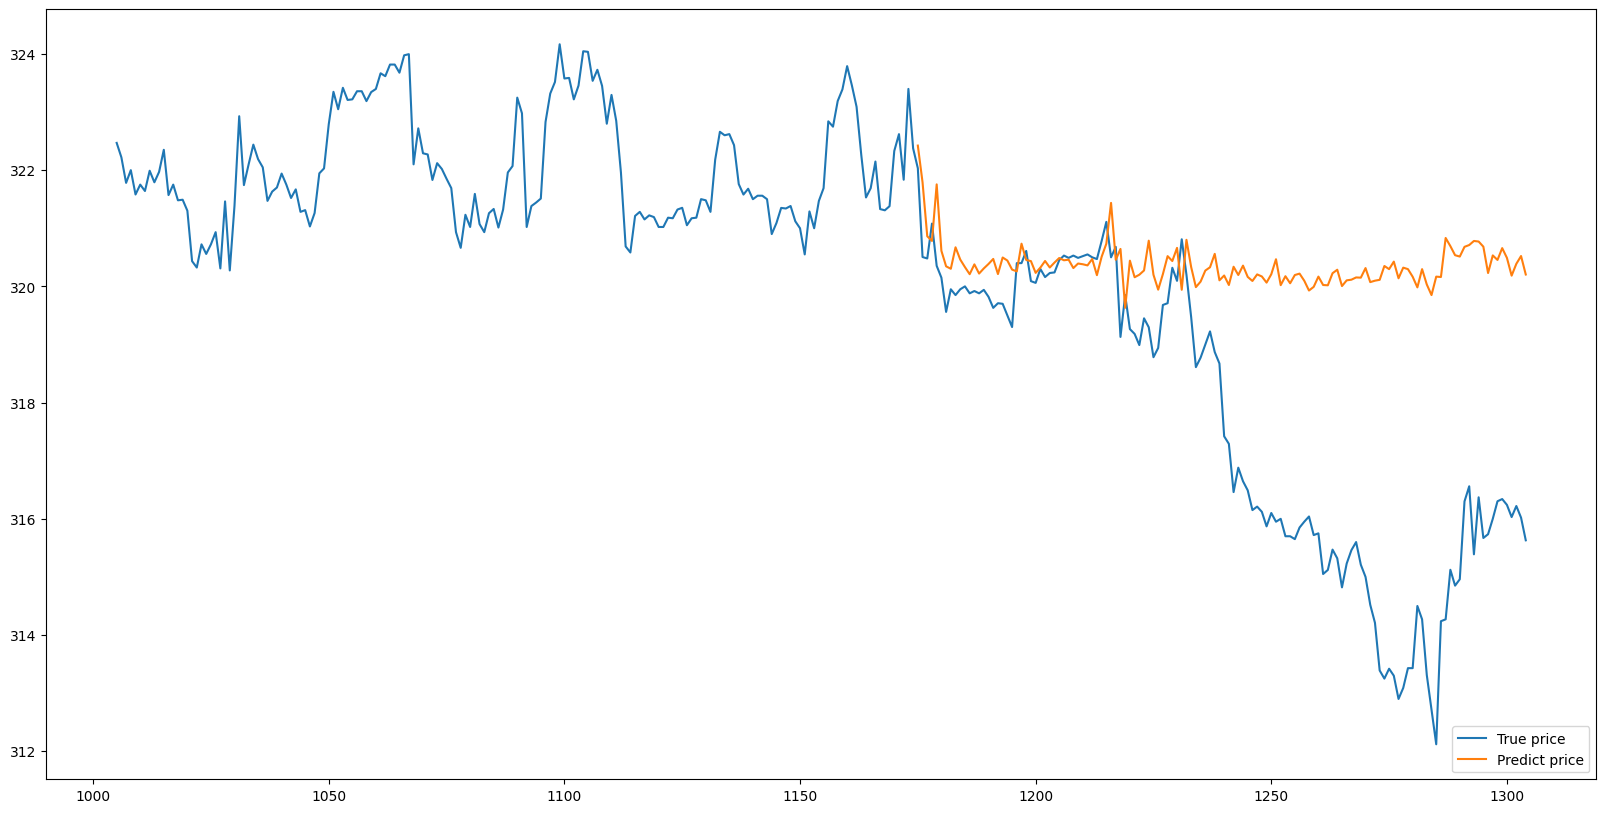

In [137]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + SMA

C:\Users\lonel\AppData\Local\Temp\ipykernel_7644\1010537535.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\lonel\AppData\Local\Temp\ipykernel_7644\1010537535.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\lonel\AppData\Local\Temp\ipykernel_7644\1010537535.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

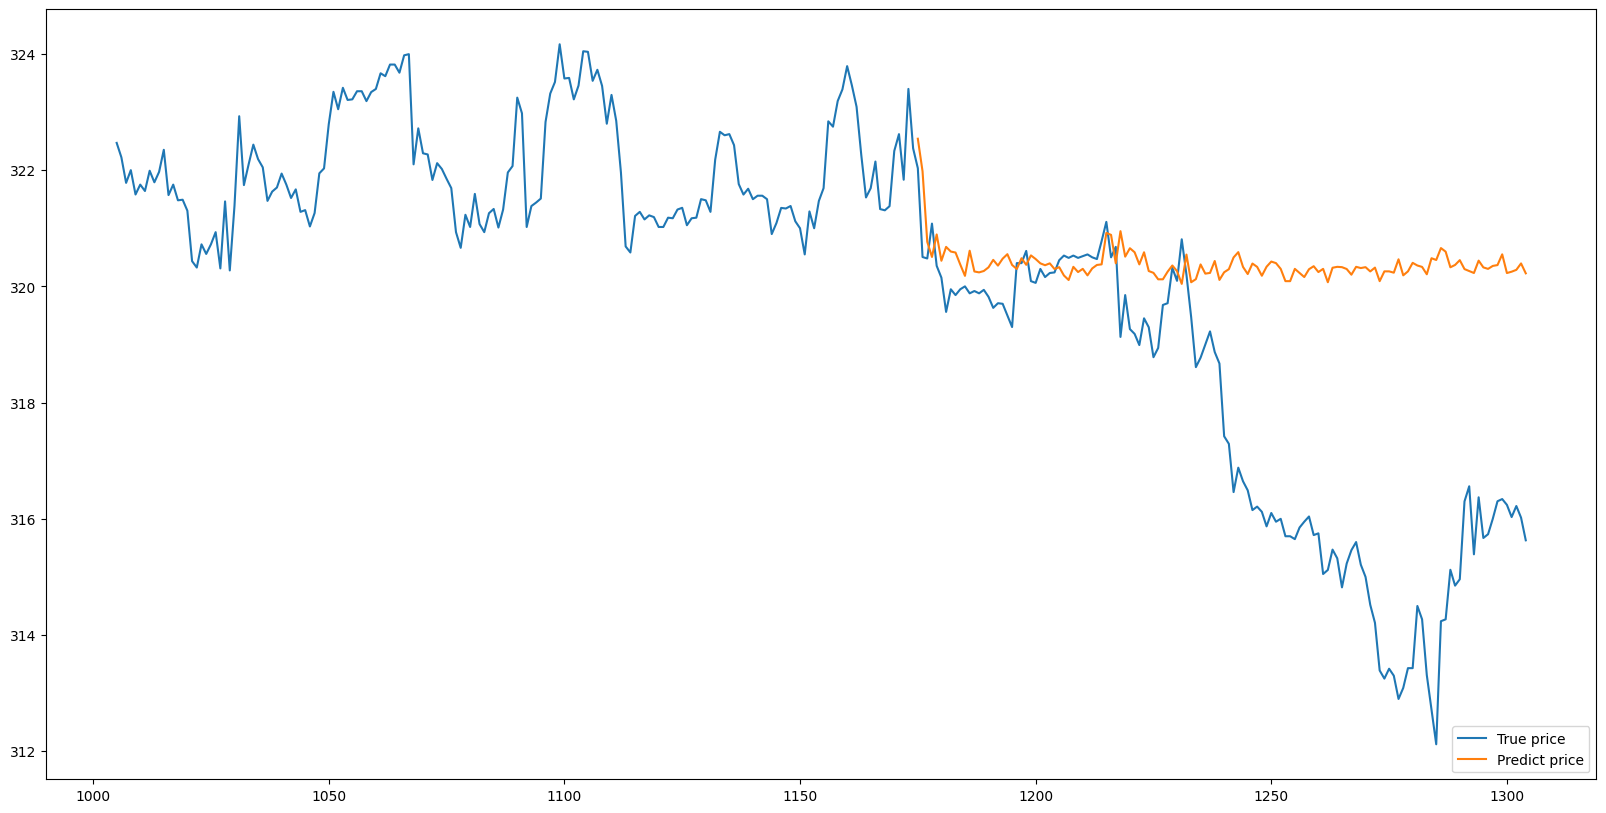

In [138]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI

C:\Users\lonel\AppData\Local\Temp\ipykernel_7644\144573520.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\lonel\AppData\Local\Temp\ipykernel_7644\144573520.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\lonel\AppData\Local\Temp\ipykernel_7644\144573520.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

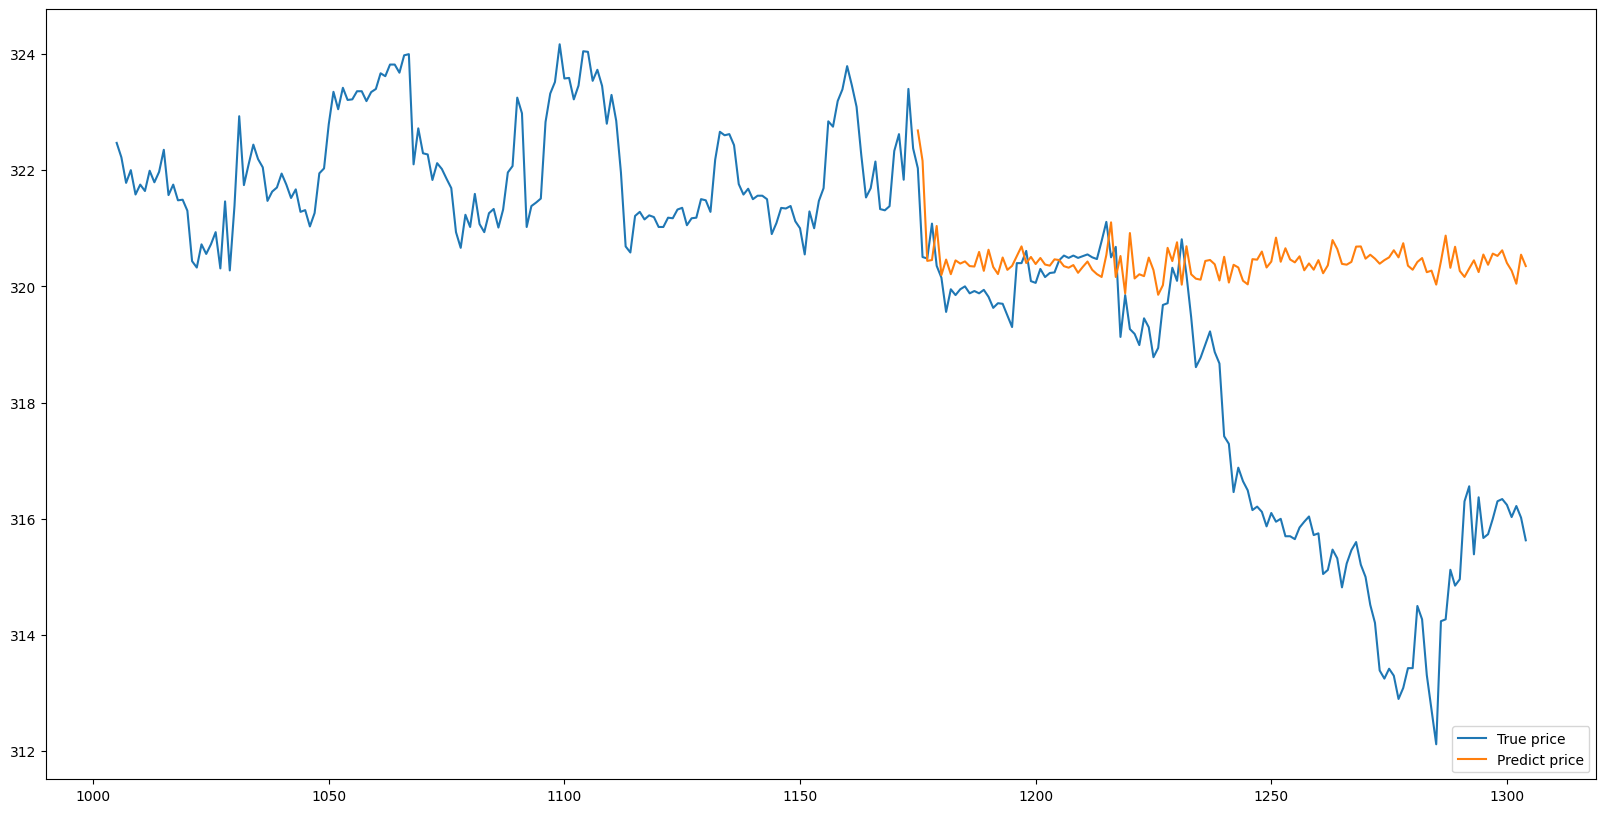

In [139]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'ROC', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'ROC', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_ROC_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_ROC_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### +ROC +SMA

C:\Users\lonel\AppData\Local\Temp\ipykernel_7644\2866562134.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\lonel\AppData\Local\Temp\ipykernel_7644\2866562134.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\lonel\AppData\Local\Temp\ipykernel_7644\2866562134.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

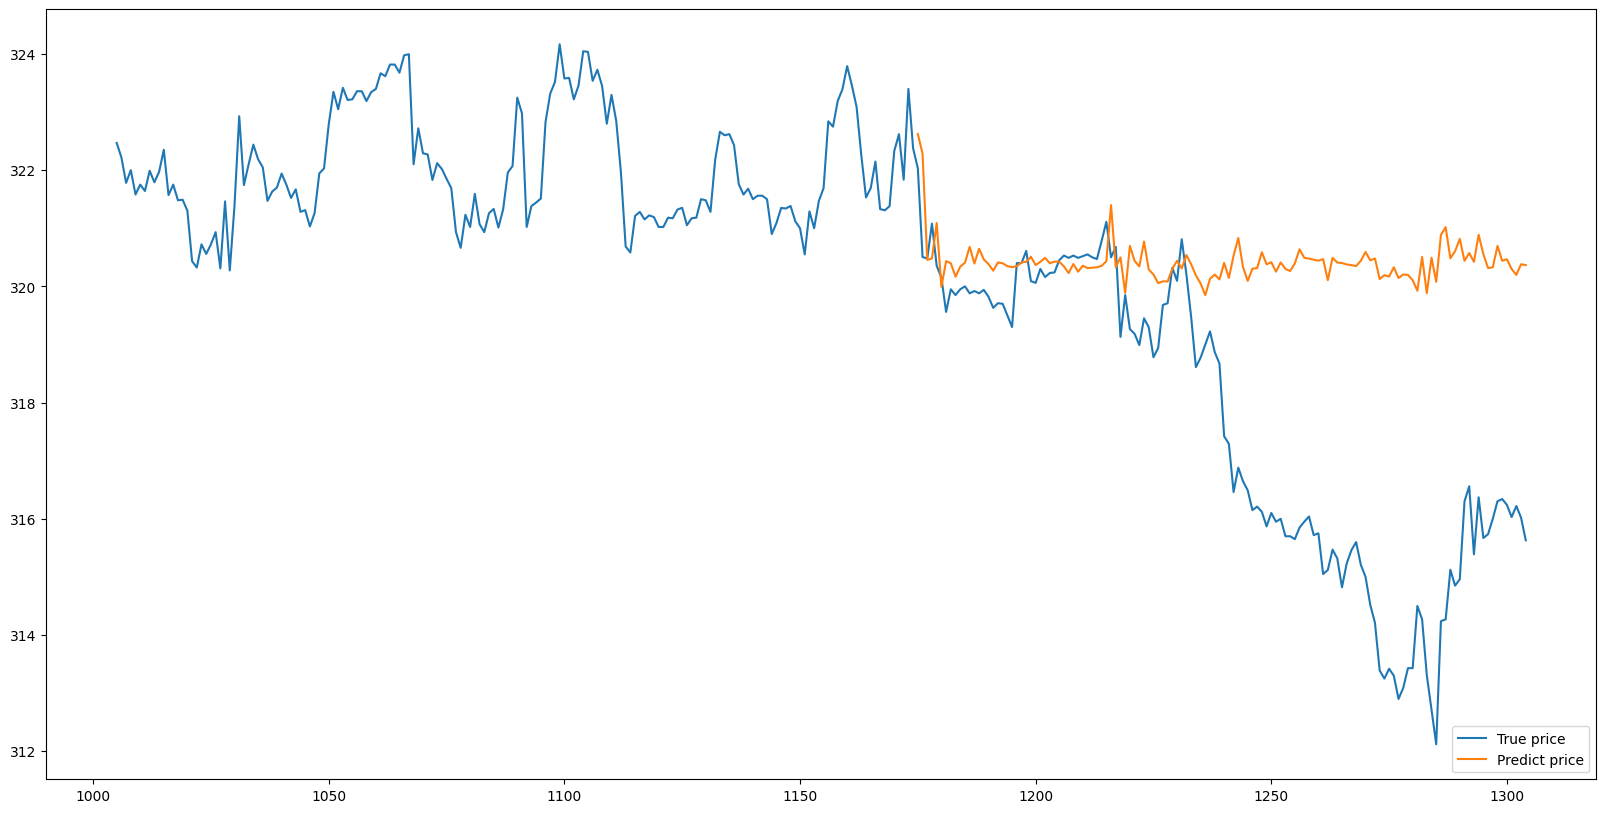

In [140]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'ROC', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'ROC', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_ROC_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_ROC_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI + SMA

C:\Users\lonel\AppData\Local\Temp\ipykernel_7644\803041197.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\lonel\AppData\Local\Temp\ipykernel_7644\803041197.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\lonel\AppData\Local\Temp\ipykernel_7644\803041197.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

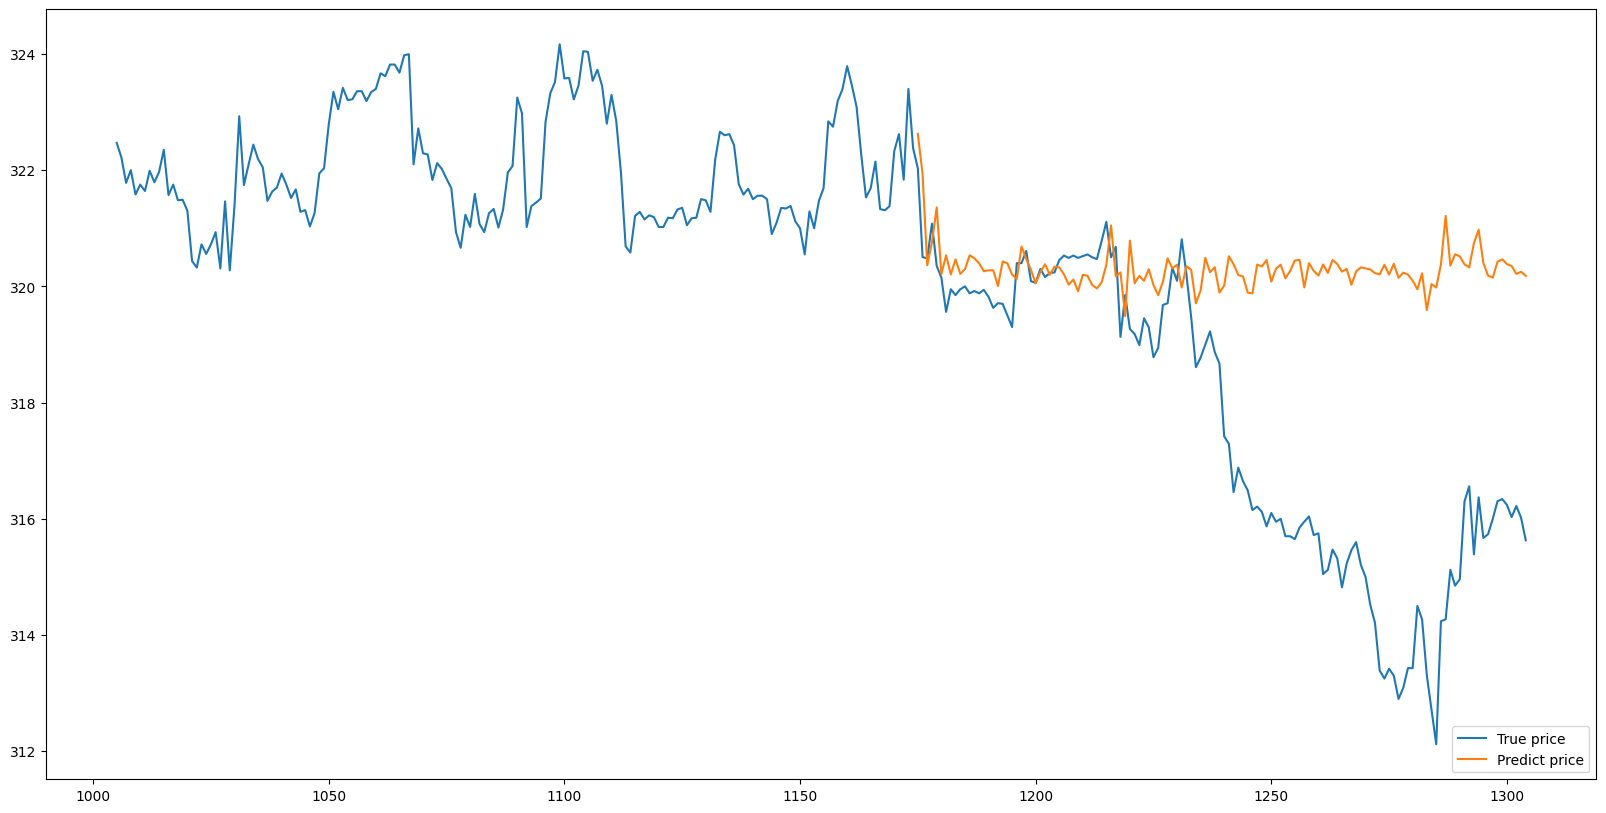

In [141]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'RSI', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'RSI', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_RSI_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_RSI_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI

C:\Users\lonel\AppData\Local\Temp\ipykernel_7644\1224954108.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\lonel\AppData\Local\Temp\ipykernel_7644\1224954108.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\lonel\AppData\Local\Temp\ipykernel_7644\1224954108.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

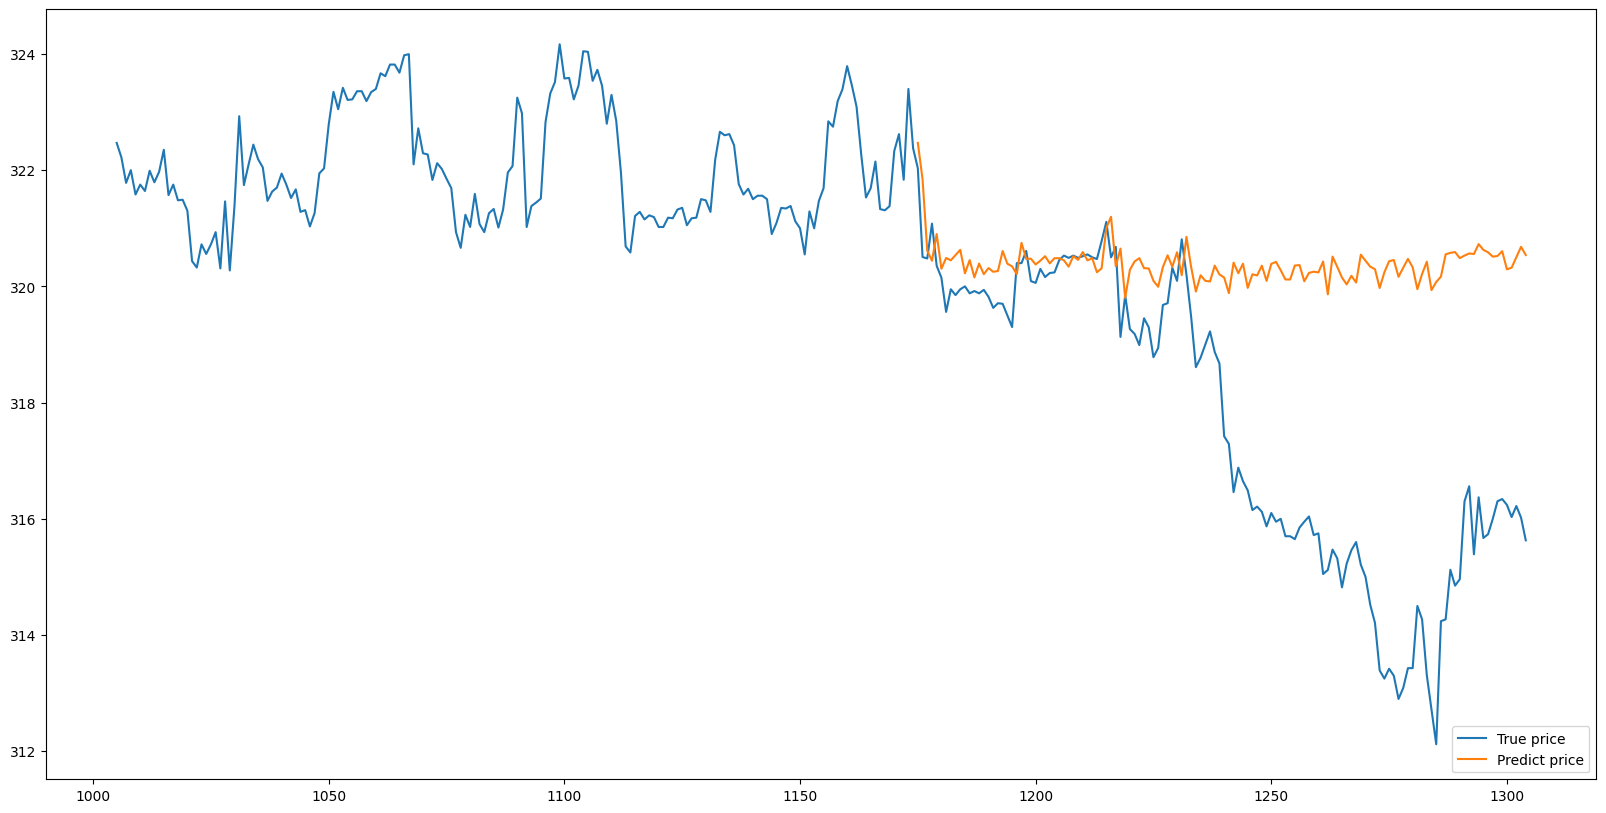

In [142]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_ROC_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_ROC_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + SMA

C:\Users\lonel\AppData\Local\Temp\ipykernel_7644\580329412.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\lonel\AppData\Local\Temp\ipykernel_7644\580329412.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\lonel\AppData\Local\Temp\ipykernel_7644\580329412.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

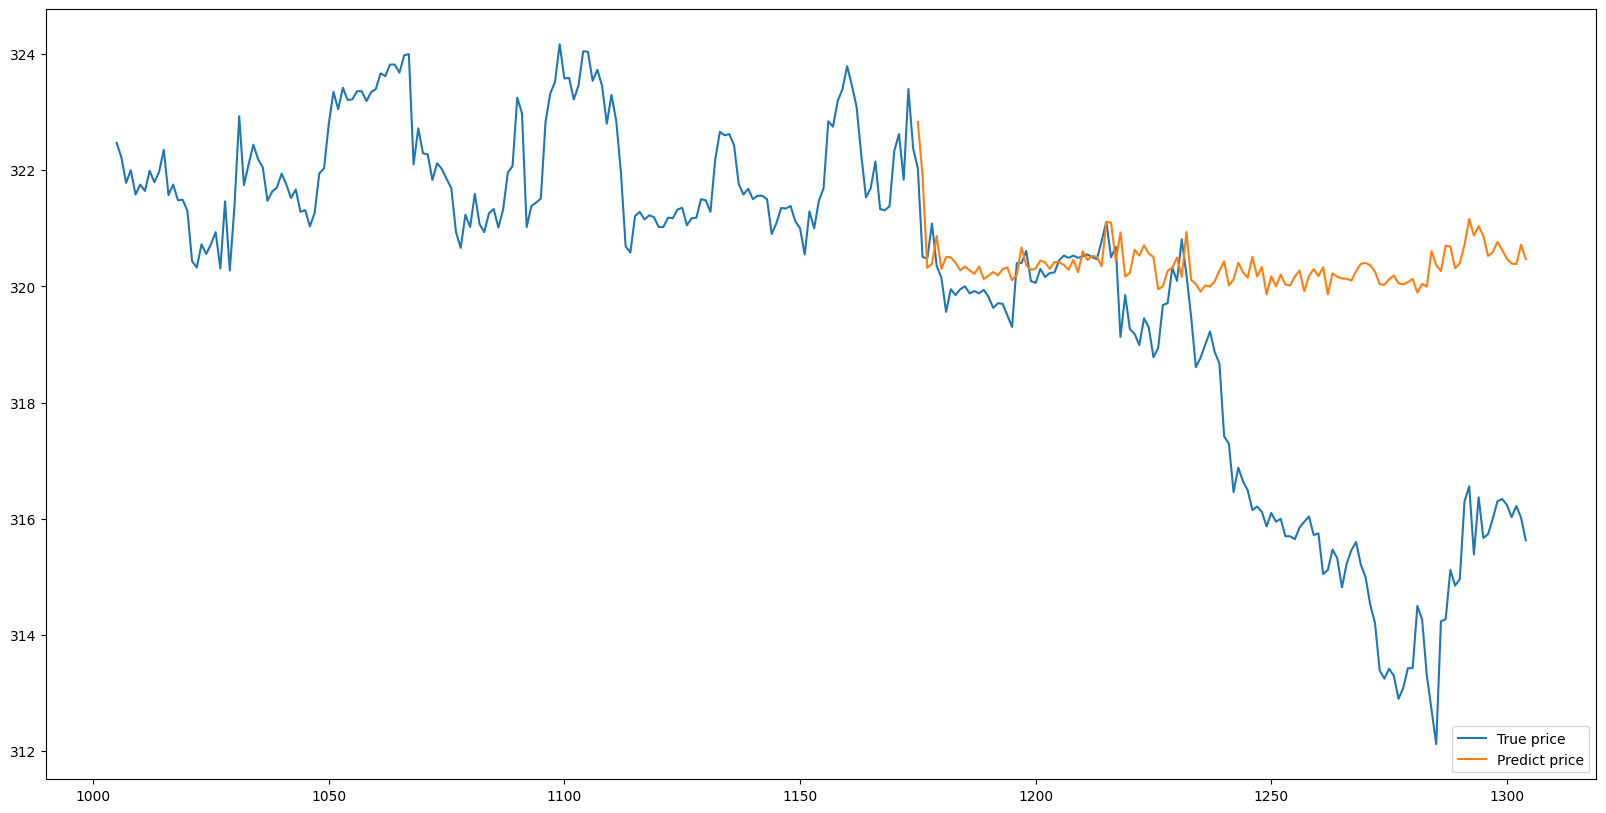

In [143]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_ROC_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_ROC_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI + SMA

C:\Users\lonel\AppData\Local\Temp\ipykernel_7644\2353105684.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\lonel\AppData\Local\Temp\ipykernel_7644\2353105684.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\lonel\AppData\Local\Temp\ipykernel_7644\2353105684.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

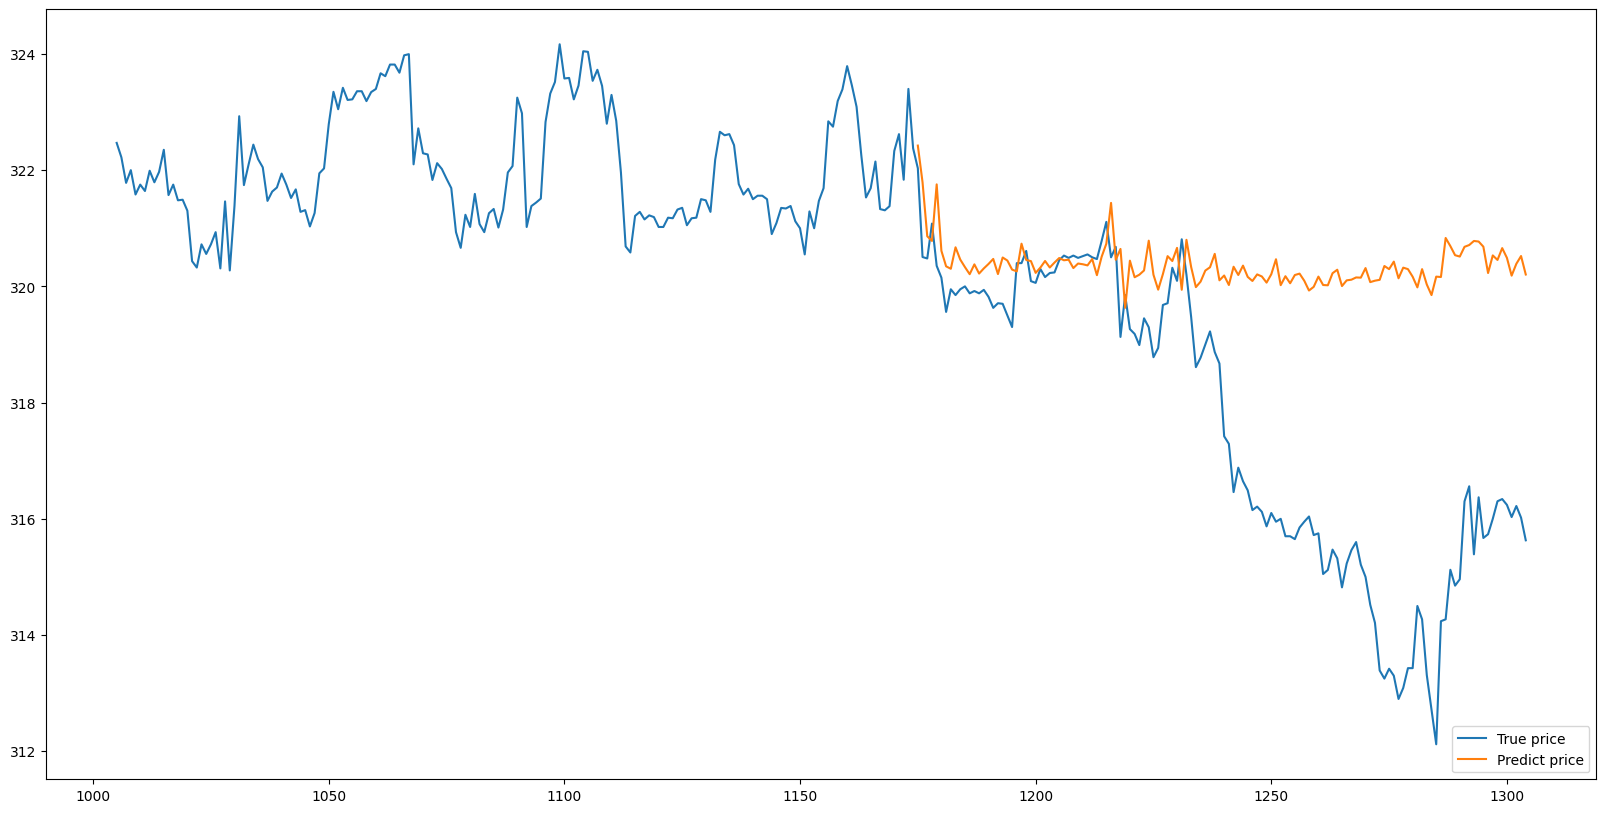

In [144]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)
    dataset["RMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_RSI_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_RSI_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()